# Goodreads Data Analysis
### Michael Barmada, mdb120@pitt.edu
---

## Table of Contents
### Part 1: Introduction
### Part 2: Data Overview and Cleanup
### Part 3: Ratings Analysis
### Part 4: Binary Sentmiment Analysis
### Part 5: Lexical Analysis
### Part 6: Titular Analysis
### Part 7: Non-Lexical Data Analysis

## Part 1: Introduction <a id=’part_1’></a>
---
Before we get into talking about the data, I highly recommend you check out [the code I used to scrape these reviews](https://github.com/Data-Science-for-Linguists-2021/Goodreads-Sentiment-Analysis/blob/main/book_scraper.py) as it may prove useful to see how I went about collecting the data (plus it took a ridiculous amount of time to get right, so). The following paragraphs constitute a brief introduction to my dataset, including information about the website itself as well as how I altered my data collection process. It is not at all essential for understanding the rest of the analysis, but I decided to include it in order to provide context for the project as a whole. 

Reviews were scraped from [goodreads.com](https://www.goodreads.com/), a website for readers to review the books they've read and share those reviews with others. It combines many elements of an audience review site (i.e. metacritic) with those of a social media platform, meaning that users can like other reviews and follow certain users to see what they've reviewed and also what they're currently reading.

Goodreads also allows users to place books in certain "shelves", a user-driven way of classifying similar books without relying on a fixed set of established keywords. For the purpose of this analysis, I decided to use the [Fantasy shelf](https://www.goodreads.com/shelf/show/fantasy), which contains links to the books most often shelved as fantasy by users.

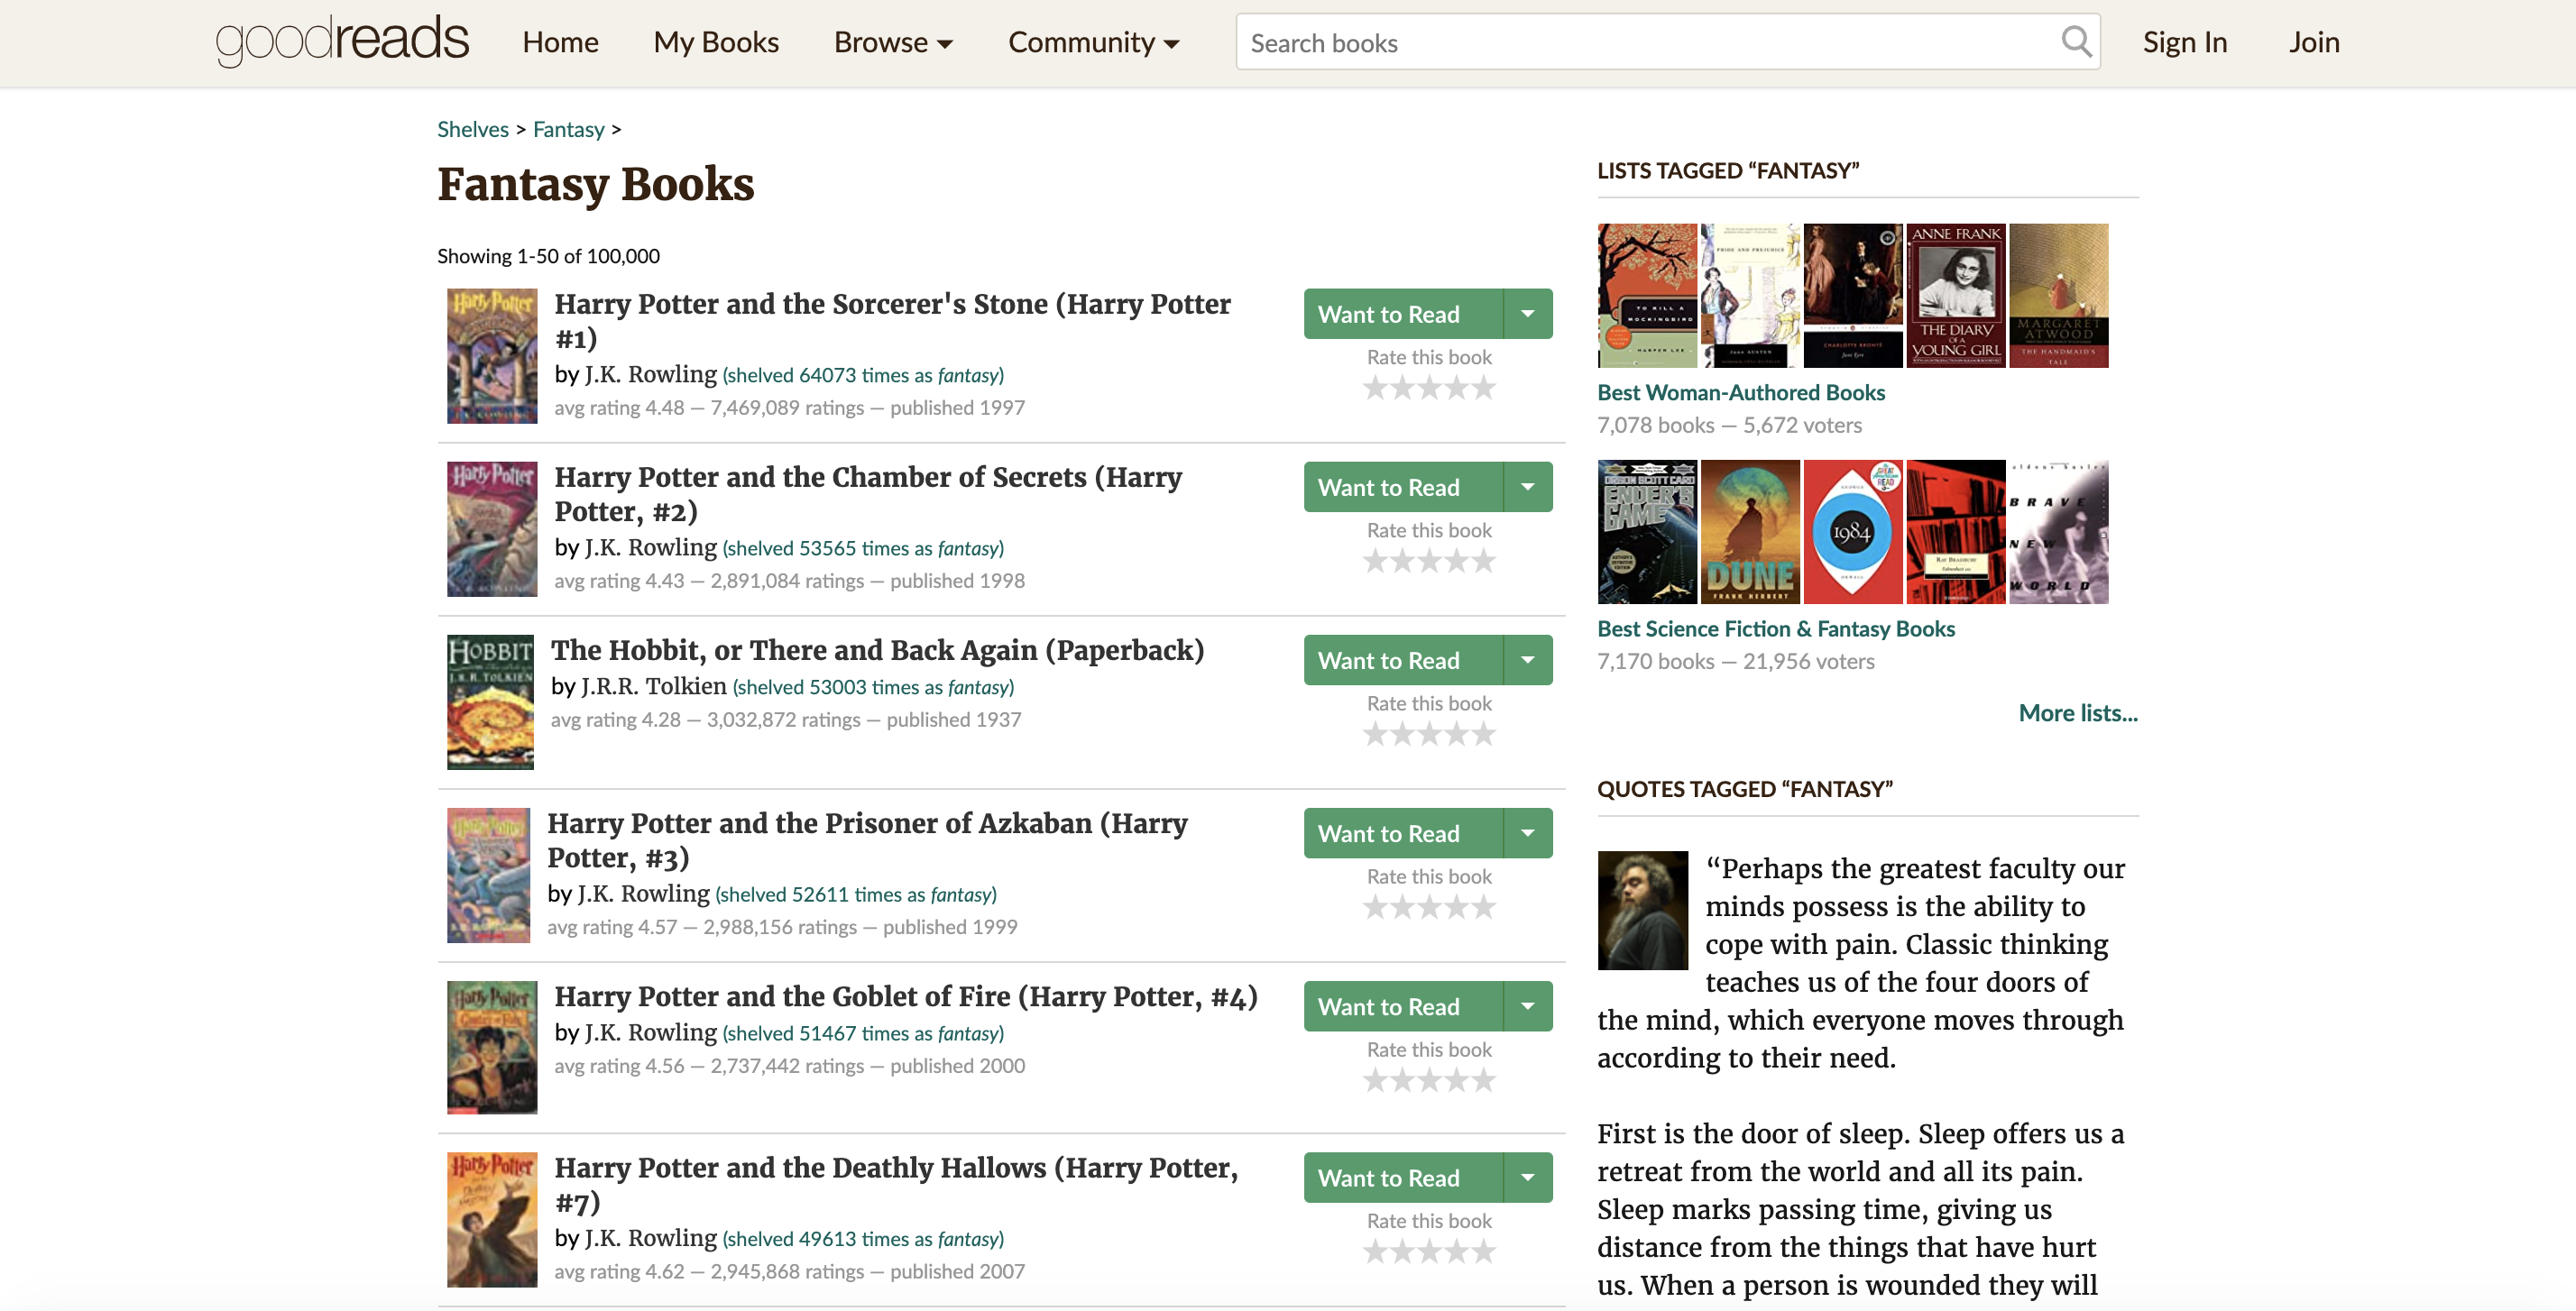

As we can see, the first few books are almost all Harry Potter. This make sense considering their popularity, but in order to get a better spread of fantasy books I decided to exclude everything but the first book in a series. I used a small piece of regex to filter out the offending book titles while scraping this page for urls...

`r'\#[^1]\d?\)'`

... and ended up with 32 good urls. A book's page only shows the 30 most popular reviews at once and only allows access to 10 pages in total. In effect, this means you can only see the top 300 reviews by default. In the first iteration of my code, I looped through these pages until I had enough data. However, since I wanted equal-ish data from each review level (1-star, 2-star, etcetera), and since these books are all very positively reviewed, I had to loop through each of the 10 pages to find enough low-score reviews and even then I sometimes didn't get all the data I wanted (I was aiming for 10 reviews per level then).

As such, I decided to alter my code. Instead of looping through the 300 most-popular reviews, I used the filter system to isolate reviews based on their rating. This came with both pros and cons. The pros were that I could now scrape significantly more data in significantly less time, as each filter displayed the 30 most popular reviews with a certain rating. This meant I could scrape all 30 reviews off the page at once, getting up to 150 reviews per book in half the time (I ended up going with 120 per book in case there were empty reviews or other issues). The biggest con was that Goodreads only allows for one filter to be in place at a time, which unfortunately includes language filters. Because of this, there are some non-English reviews that will need to be filtered out before analysis can really begin.

## Part 2: Data Overview and Cleanup 
<a id=’part_2’></a>

---

In [1]:
import nltk
import sklearn
import matplotlib.pyplot as plt
import numpy as np
import regex as re
import pandas as pd

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%pprint

Pretty printing has been turned OFF


In [2]:
sklearn.__version__

'0.22'

First thing's first, we've got to load in our data. We'll call the new data frame reviews_df.

In [3]:
reviews_df = pd.read_csv('data/compiled_df.csv')

In [4]:
reviews_df.info()
pd.concat([reviews_df.head(3),reviews_df.sample(10), reviews_df.tail(3)])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3778 entries, 0 to 3777
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Title    3778 non-null   object
 1   Year     3778 non-null   int64 
 2   Genres   3778 non-null   object
 3   Rating   3778 non-null   int64 
 4   Likes    3778 non-null   object
 5   Date     3778 non-null   object
 6   Shelves  3778 non-null   object
 7   Text     3778 non-null   object
dtypes: int64(2), object(6)
memory usage: 236.2+ KB


,Title,Year,Genres,Rating,Likes,Date,Shelves,Text
0,Harry Potter and the Sorcerer's Stone,1997,"['Fantasy', 'Fiction', 'Young Adult', 'Fantasy...",5,1532 likes,"Nov 11, 2019","['absolute-favorites', 'audiobook']",\nStuck at home? Got some time on your hands?...
1,Harry Potter and the Sorcerer's Stone,1997,"['Fantasy', 'Fiction', 'Young Adult', 'Fantasy...",5,1509 likes,"Jun 03, 2011","['favorites', 'book-to-movie', 'lib-read', 'mi...",I'm going to keep this brief since there isn't...
2,Harry Potter and the Sorcerer's Stone,1997,"['Fantasy', 'Fiction', 'Young Adult', 'Fantasy...",5,802 likes,"Dec 10, 2009","['books-i-own', '5-star-excellent', 'favorites...",My original review was a comparison of sorts b...
2887,The Lies of Locke Lamora,2006,"['Fantasy', 'Fiction', 'Adventure', 'Adult', '...",2,5 likes,"Jul 31, 2020",[],Actuall rating: 1.5 stars.The blurb sounded so...
3145,Assassin's Apprentice,1995,"['Fantasy', 'Fiction', 'Fantasy', 'Epic Fantas...",3,28 likes,"Feb 18, 2018","['1audio', '2fiction', '3series', 'fantasy']",I've heard a lot about this for a long time & ...
824,The Golden Compass,1995,"['Fantasy', 'Young Adult', 'Fiction', 'Childre...",5,642 likes,"Nov 01, 2014","['fantasy', 'children-of-all-ages', 'sci-fi', ...","This novel is an absolute work of pure genius,..."
225,"The Hobbit, or There and Back Again",1937,"['Fantasy', 'Classics', 'Fiction', 'Adventure'...",4,120 likes,"Aug 19, 2012",[],this is not a review.this is smack-talk.me and...
1339,Six of Crows,2015,"['Fantasy', 'Young Adult', 'Fiction', 'Young A...",5,520 likes,"Mar 14, 2015","['fantasy', 'favorites']",\n\n“This isn't a job for trained soldiers and...
2641,The Way of Kings,2010,"['Fantasy', 'Fiction', 'Fantasy', 'Epic Fantas...",2,14 likes,"Oct 14, 2015",['fantasy'],Minus 1 star for writing that annoyed me (repe...
74,Harry Potter and the Sorcerer's Stone,1997,"['Fantasy', 'Fiction', 'Young Adult', 'Fantasy...",3,400 likes,"Feb 16, 2009","['1990-1999', 'ya', 'fantasy', 'potteresque', ...",On my list of reasons why my daughters are the...


In [120]:
# A look at our books...

reviews_df.Title.unique()
len(reviews_df.Title.unique())

Index(['A Court of Thorns and Roses', 'A Darker Shade of Magic',
       'A Game of Thrones', 'A Wizard of Earthsea', 'American Gods',
       'Assassin's Apprentice', 'Eragon',
       'Good Omens: The Nice and Accurate Prophecies of Agnes Nutter, Witch',
       'Graceling', 'Harry Potter and the Sorcerer's Stone', 'Neverwhere',
       'Six of Crows', 'Stardust', 'The Color of Magic',
       'The Eye of the World', 'The Fellowship of the Ring',
       'The Final Empire', 'The Golden Compass',
       'The Hobbit, or There and Back Again', 'The Lies of Locke Lamora',
       'The Lightning Thief', 'The Lion, the Witch and the Wardrobe',
       'The Lord of the Rings', 'The Name of the Wind', 'The Night Circus',
       'The Ocean at the End of the Lane', 'The Princess Bride',
       'The Subtle Knife', 'The Way of Kings', 'Throne of Glass', 'Twilight',
       'Uprooted'],
      dtype='object', name='Title')

32

As we can see, the data from book_scraper.py is a little unorganized. Let's get to fixing that...

### Text Cleaning

In [6]:
# Regex for removing emoji's and URLs...

def textcleaner(text):
    emoji_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    text = emoji_pattern.sub(r'',text)

    url_pattern = re.compile(pattern = r"https:\/\/\S+\b|www\.\S+\b")
    text = url_pattern.sub(r'',text)
    
    return text.encode('ascii', 'ignore').decode('ascii') # Last line of defense: if it can't be encoded into ascii, just get rid of it (the nuclear option)

In [7]:
reviews_df.Text = reviews_df.Text.map(textcleaner)

### Eliminating non-English reviews

In [8]:
# Claassify each review's language with langdetect...

from langdetect import detect, DetectorFactory
DetectorFactory().seed = 0 # langdetect results are non-deterministic; we use a seed to generate consistent results

def langzr(text):
    try:
        return detect(text)
    except:
        return

In [9]:
import time

start = time.time()
reviews_df["Lang"] = reviews_df.Text.map(langzr)
end = time.time()

print("Duration:", end - start)

Duration: 38.79892563819885


Not ideal, but it gets results...

In [10]:
reviews_df.Lang.value_counts()

en    3549
es      76
it      30
de      26
tr      11
hr       9
pt       8
sv       6
fr       6
id       4
pl       3
nl       3
ro       2
da       2
cy       2
af       2
no       2
fi       2
et       1
sq       1
hu       1
ca       1
cs       1
vi       1
lv       1
so       1
lt       1
Name: Lang, dtype: int64

In [11]:
# Look at just the English reviews and get rid of the (now redundant) Lang column...

reviews_df = reviews_df[reviews_df.Lang == 'en']
reviews_df.drop(['Lang'], axis=1, inplace = True)

In [12]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3549 entries, 0 to 3777
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Title    3549 non-null   object
 1   Year     3549 non-null   int64 
 2   Genres   3549 non-null   object
 3   Rating   3549 non-null   int64 
 4   Likes    3549 non-null   object
 5   Date     3549 non-null   object
 6   Shelves  3549 non-null   object
 7   Text     3549 non-null   object
dtypes: int64(2), object(6)
memory usage: 249.5+ KB


### SpaCy Tokenization

In [13]:
import spacy
from spacy.lang.en import English
from spacy import displacy
import en_core_web_sm

nlp = en_core_web_sm.load()
nlp.add_pipe('sentencizer')

reviews_df['Spacy'] = reviews_df.Text.map(nlp)

In [14]:
reviews_df.head()

,Title,Year,Genres,Rating,Likes,Date,Shelves,Text,Spacy
0,Harry Potter and the Sorcerer's Stone,1997,"['Fantasy', 'Fiction', 'Young Adult', 'Fantasy...",5,1532 likes,"Nov 11, 2019","['absolute-favorites', 'audiobook']",\nStuck at home? Got some time on your hands?...,"( \n, Stuck, at, home, ?, Got, some, time, on,..."
1,Harry Potter and the Sorcerer's Stone,1997,"['Fantasy', 'Fiction', 'Young Adult', 'Fantasy...",5,1509 likes,"Jun 03, 2011","['favorites', 'book-to-movie', 'lib-read', 'mi...",I'm going to keep this brief since there isn't...,"(I, 'm, going, to, keep, this, brief, since, t..."
2,Harry Potter and the Sorcerer's Stone,1997,"['Fantasy', 'Fiction', 'Young Adult', 'Fantasy...",5,802 likes,"Dec 10, 2009","['books-i-own', '5-star-excellent', 'favorites...",My original review was a comparison of sorts b...,"(My, original, review, was, a, comparison, of,..."
3,Harry Potter and the Sorcerer's Stone,1997,"['Fantasy', 'Fiction', 'Young Adult', 'Fantasy...",5,843 likes,"Jan 08, 2013","['fantasy', 'own', 'series', 'young-adult']",One of my first jobs was at a bookstore. When ...,"(One, of, my, first, jobs, was, at, a, booksto..."
4,Harry Potter and the Sorcerer's Stone,1997,"['Fantasy', 'Fiction', 'Young Adult', 'Fantasy...",5,1447 likes,"Jun 10, 2012",['all-time-favorites'],Rereading for the 3rd time for the group read....,"(Rereading, for, the, 3rd, time, for, the, gro..."


In [15]:
reviews_df['Toks'] = reviews_df.Spacy.map(len) # Adds token column for each review
reviews_df['Types'] = reviews_df.Spacy.map(lambda t: len(set([tok.text for tok in t]))) # Adds type column
reviews_df['TTR'] = reviews_df.Types/reviews_df.Toks # Calculates ttr for each review

### Date and Likes adjustment

In [16]:
reviews_df.Date = pd.to_datetime(reviews_df.Date).dt.date # Convert Date values to datetime objects
reviews_df.Likes = reviews_df.Likes.map(lambda l: int(l.split()[0])) # Convert Likes from str to int

In [17]:
reviews_df.head()

,Title,Year,Genres,Rating,Likes,Date,Shelves,Text,Spacy,Toks,Types,TTR
0,Harry Potter and the Sorcerer's Stone,1997,"['Fantasy', 'Fiction', 'Young Adult', 'Fantasy...",5,1532,2019-11-11,"['absolute-favorites', 'audiobook']",\nStuck at home? Got some time on your hands?...,"( \n, Stuck, at, home, ?, Got, some, time, on,...",451,255,0.565410
1,Harry Potter and the Sorcerer's Stone,1997,"['Fantasy', 'Fiction', 'Young Adult', 'Fantasy...",5,1509,2011-06-03,"['favorites', 'book-to-movie', 'lib-read', 'mi...",I'm going to keep this brief since there isn't...,"(I, 'm, going, to, keep, this, brief, since, t...",411,224,0.545012
2,Harry Potter and the Sorcerer's Stone,1997,"['Fantasy', 'Fiction', 'Young Adult', 'Fantasy...",5,802,2009-12-10,"['books-i-own', '5-star-excellent', 'favorites...",My original review was a comparison of sorts b...,"(My, original, review, was, a, comparison, of,...",333,177,0.531532
3,Harry Potter and the Sorcerer's Stone,1997,"['Fantasy', 'Fiction', 'Young Adult', 'Fantasy...",5,843,2013-01-08,"['fantasy', 'own', 'series', 'young-adult']",One of my first jobs was at a bookstore. When ...,"(One, of, my, first, jobs, was, at, a, booksto...",419,223,0.532220
4,Harry Potter and the Sorcerer's Stone,1997,"['Fantasy', 'Fiction', 'Young Adult', 'Fantasy...",5,1447,2012-06-10,['all-time-favorites'],Rereading for the 3rd time for the group read....,"(Rereading, for, the, 3rd, time, for, the, gro...",364,181,0.497253


### Genres and Shelves cleaning

In [18]:
# The Genres and Shelves columns are actually stored as string values despite appearing like lists...

type(reviews_df.Genres.iloc[0])
type(reviews_df.Shelves.iloc[0])

<class 'str'>

<class 'str'>

In [19]:
pattern = re.compile("\'.+?\'")

reviews_df.Genres = reviews_df.Genres.map(pattern.findall)
reviews_df.Shelves = reviews_df.Shelves.map(pattern.findall)
reviews_df.sample(5)

,Title,Year,Genres,Rating,Likes,Date,Shelves,Text,Spacy,Toks,Types,TTR
381,The Fellowship of the Ring,1954,"['Fantasy', 'Classics', 'Fiction', 'Adventure'...",4,129,2012-01-07,"['1-fiction', '3-multi-book-series']",4+ out of 5 stars to The Fellowship of the Rin...,"(4, +, out, of, 5, stars, to, The, Fellowship,...",1041,447,0.429395
1603,Throne of Glass,2012,"['Fantasy', 'Young Adult', 'Romance', 'Fiction...",1,101,2016-06-29,['just-shit'],New review; lololololol this was trash how did...,"(New, review, ;, lololololol, this, was, trash...",788,355,0.450508
2153,Neverwhere,1996,"['Fantasy', 'Fiction', 'Fantasy', 'Urban Fanta...",2,117,2007-10-23,['fantasy'],Picture Hitch Hiker's Guide to the Galaxy. Rea...,"(Picture, Hitch, Hiker, 's, Guide, to, the, Ga...",226,146,0.646018
2642,The Way of Kings,2010,"['Fantasy', 'Fiction', 'Fantasy', 'Epic Fantas...",2,13,2012-08-26,"['fantasy', 'own-it-pb-or-hc', 'not-my-type-of...",I've waited so long to write the review that I...,"(I, 've, waited, so, long, to, write, the, rev...",204,129,0.632353
2279,A Court of Thorns and Roses,2015,"['Fantasy', 'Romance', 'Young Adult', 'New Adu...",2,206,2015-05-09,"['my-kindle-challenges-me', '2016-reads', 'gen...",Edit 05/02 : So. GUYS. A Court of Mist and Fur...,"(Edit, 05/02, :, So, ., GUYS, ., A, Court, of,...",936,406,0.433761


In [20]:
# Much better

type(reviews_df.Genres.iloc[0])
type(reviews_df.Shelves.iloc[0])

<class 'list'>

<class 'list'>

In [21]:
# Take a look at all genre tags...

from collections import Counter

genre_list = Counter()
for row in reviews_df.Genres:
    for tag in row:
        genre_list.update([tag])

len(genre_list)
genre_list

47

Counter({"'Fantasy'": 11154, "'Young Adult'": 3585, "'Fiction'": 3549, "'Adventure'": 2769, "'Science Fiction Fantasy'": 2400, "'Magic'": 2259, "'High Fantasy'": 1904, "'Audiobook'": 1861, "'Adult'": 1653, "'Childrens'": 1339, "'Romance'": 1155, "'Epic Fantasy'": 1112, "'Science Fiction'": 940, "'Classics'": 879, "'Paranormal'": 688, "'Young Adult Fantasy'": 682, "'Urban Fantasy'": 635, "'Humor'": 632, "'Middle Grade'": 555, "'Novels'": 538, "'Epic'": 453, "'Historical'": 349, "'Fairy Tales'": 349, "'New Adult'": 344, "'Mythology'": 343, "'Dragons'": 338, "'Comedy'": 316, "'Teen'": 233, "'Mystery'": 232, "'Historical Fiction'": 231, "'Magical Realism'": 229, "'Retellings'": 229, "'Steampunk'": 218, "'Supernatural'": 211, "'Horror'": 195, "'Vampires'": 118, "'Paranormal Romance'": 118, "'Greek Mythology'": 116, "'Crime'": 116, "'Christian'": 114, "'Christian Fiction'": 114, "'Contemporary'": 111, "'LGBT'": 111, "'Fairies'": 111, "'Fae'": 111, "'Adult Fiction'": 111, "'Literature'": 99})

In [22]:
# Take a look at most commonly-used shelves (& eliminate those used only once)...

shelf_list = Counter()
for row in reviews_df.Shelves:
    for tag in row:
        shelf_list.update([tag])

print('Before:', len(shelf_list))
clean_list = [sh for sh in shelf_list if shelf_list[sh] > 1]
print('After:', len(clean_list))

shelf_list.most_common(20)

Before: 2556
After: 1125


[("'fantasy'", 1077), ("'young-adult'", 197), ("'favorites'", 185), ("'fiction'", 127), ("'reviewed'", 112), ("'classics'", 91), ("'owned'", 84), ("'ya'", 79), ("'own'", 72), ("'romance'", 70), ("'audiobook'", 66), ("'adult'", 65), ("'magic'", 57), ("'dnf'", 56), ("'epic-fantasy'", 50), ("'series'", 47), ("'2019'", 47), ("'favourites'", 43), ("'adventure'", 41), ("'audiobooks'", 41)]

In [23]:
# Remove shelf tags from nonlex_df.Shelves that occur only once. First we need a new function to filter the lists...

def shelf_duster(mess):
    clean = [sh for sh in mess if sh in clean_list]
    return clean

reviews_df.Shelves = reviews_df.Shelves.map(shelf_duster)
reviews_df.sample(10)

,Title,Year,Genres,Rating,Likes,Date,Shelves,Text,Spacy,Toks,Types,TTR
959,The Final Empire,2006,"['Fantasy', 'Fiction', 'Fantasy', 'High Fantas...",5,655,2013-12-13,['favorites'],WOAH. That was a crazy epic adventure full of ...,"(WOAH, ., That, was, a, crazy, epic, adventure...",29,28,0.965517
2762,The Ocean at the End of the Lane,2013,"['Fantasy', 'Fiction', 'Magical Realism', 'Hor...",2,20,2017-07-19,"['x-coverporn', 'z-2017reads', 'literary-ficti...",2.5 stars. Do you ever read a book that's good...,"(2.5, stars, ., Do, you, ever, read, a, book, ...",284,148,0.521127
3696,A Wizard of Earthsea,1968,"['Fantasy', 'Fiction', 'Young Adult', 'Classic...",1,5,2009-09-15,[],A Wizard of Earthsea was one of the worst book...,"(A, Wizard, of, Earthsea, was, one, of, the, w...",160,104,0.650000
483,The Name of the Wind,2007,"['Fantasy', 'Fiction', 'Fantasy', 'Epic Fantas...",1,770,2009-10-23,[],Okay. Wow. Let's back the hell up here. How is...,"(Okay, ., Wow, ., Let, 's, back, the, hell, up...",836,450,0.538278
3474,The Subtle Knife,1997,"['Fantasy', 'Young Adult', 'Fiction', 'Childre...",2,9,2011-04-01,[],It gets progressively worse as the need to hit...,"(It, gets, progressively, worse, as, the, need...",368,212,0.576087
901,The Final Empire,2006,"['Fantasy', 'Fiction', 'Fantasy', 'High Fantas...",2,43,2018-09-19,['adult'],Sigh.... I tried but I just couldnt get into it,"(Sigh, ...., I, tried, but, I, just, could, nt...",12,11,0.916667
238,"The Hobbit, or There and Back Again",1937,"['Fantasy', 'Classics', 'Fiction', 'Adventure'...",5,375,2007-05-26,"['multiplereads', 'halcyondaysofmyyouth', 'pos...",There are some days when I actually think that...,"(There, are, some, days, when, I, actually, th...",332,190,0.572289
1571,Throne of Glass,2012,"['Fantasy', 'Young Adult', 'Romance', 'Fiction...",4,566,2019-03-29,"['fantasy', 'on-app', 'books-to-read-in-romani...",4.45/5 Full review on my Blog: The Dacian She-...,"(4.45/5, Full, review, on, my, Blog, :, The, D...",950,405,0.426316
2214,Neverwhere,1996,"['Fantasy', 'Fiction', 'Fantasy', 'Urban Fanta...",2,117,2007-10-23,['fantasy'],Picture Hitch Hiker's Guide to the Galaxy. Rea...,"(Picture, Hitch, Hiker, 's, Guide, to, the, Ga...",226,146,0.646018
3060,Assassin's Apprentice,1995,"['Fantasy', 'Fiction', 'Fantasy', 'Epic Fantas...",4,414,2015-07-29,"['fantasy-all', 'own']",Reread this AGAIN because I am going to read a...,"(Reread, this, AGAIN, because, I, am, going, t...",719,314,0.436718


### Reindexing + Sorting

Now that our dataframe is a little more fleshed out and cleaned up, let's reindex. First, we'll reset it using the book's title. Then, we'll sort both titles and reviews in ascending order.

In [24]:
reviews_df.set_index("Title", inplace = True)
reviews_df.sort_values(["Title", "Rating"], inplace = True)

In [25]:
pd.concat([reviews_df.head(3),reviews_df.sample(10), reviews_df.tail(3)])

,Year,Genres,Rating,Likes,Date,Shelves,Text,Spacy,Toks,Types,TTR
Title,,,,,,,,,,,
A Court of Thorns and Roses,2015,"['Fantasy', 'Romance', 'Young Adult', 'New Adu...",1,274,2018-03-26,"['fantasy', 'cover-porn', 'retelling', '1-star...","Me to Sarah J Maas:""Do you lie awake at night ...","(Me, to, Sarah, J, Maas:""Do, you, lie, awake, ...",1810,680,0.375691
A Court of Thorns and Roses,2015,"['Fantasy', 'Romance', 'Young Adult', 'New Adu...",1,198,2019-03-14,[],"""Swift as lightning, he lashed out, grabbing t...","("", Swift, as, lightning, ,, he, lashed, out, ...",1665,673,0.404204
A Court of Thorns and Roses,2015,"['Fantasy', 'Romance', 'Young Adult', 'New Adu...",1,139,2015-05-20,[],I have a hard time rating this book because of...,"(I, have, a, hard, time, rating, this, book, b...",914,343,0.375274
A Wizard of Earthsea,1968,"['Fantasy', 'Fiction', 'Young Adult', 'Classic...",4,372,2016-09-02,[],"The hunger of a dragon is slow to wake, but ha...","(The, hunger, of, a, dragon, is, slow, to, wak...",1330,523,0.393233
Twilight,2005,"['Young Adult', 'Fantasy', 'Romance', 'Fiction...",3,1940,2007-11-21,[],I actually had to give this book three separat...,"(I, actually, had, to, give, this, book, three...",693,327,0.471861
The Subtle Knife,1997,"['Fantasy', 'Young Adult', 'Fiction', 'Childre...",2,2,2021-01-18,[],"For me, it was only fitfully interesting and e...","(For, me, ,, it, was, only, fitfully, interest...",173,112,0.647399
A Court of Thorns and Roses,2015,"['Fantasy', 'Romance', 'Young Adult', 'New Adu...",4,587,2014-10-24,[],This was a solid start to this new series! I'm...,"(This, was, a, solid, start, to, this, new, se...",57,44,0.771930
A Wizard of Earthsea,1968,"['Fantasy', 'Fiction', 'Young Adult', 'Classic...",5,60,2010-07-02,"['author-knows-my-life', 'must-read-again', 'a...",I couldnt have chosen a better time to experie...,"(I, could, nt, have, chosen, a, better, time, ...",669,304,0.454410
Throne of Glass,2012,"['Fantasy', 'Young Adult', 'Romance', 'Fiction...",1,132,2018-06-19,"['2018', 'fantasy']",Whew.Celaena Sardothien is the best assassin i...,"(Whew, ., Celaena, Sardothien, is, the, best, ...",303,142,0.468647


Much better!

## Part 3: Rating Analysis
---

### Lexical Data

In [26]:
reviews_df.Rating.value_counts()

5    748
4    741
1    694
2    683
3    683
Name: Rating, dtype: int64

As we can see, our data for ratings did not come out perfectly even. We can use sample weights to balance this out a bit in our analysis

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(reviews_df.Text, reviews_df.Rating, 
                                                    test_size = 0.20, random_state = 0)

# sweight= compute_sample_weight('balanced', reviews_df.Rating) # Sample weights

clf = MultinomialNB()
Vzer = TfidfVectorizer(max_df=0.5, min_df=2, stop_words="english")
pipe = Pipeline([('tfidf', Vzer), ('clf',clf)])

param_grid = {
    'clf__alpha': [0.01, 0.1, 1],
    'tfidf__max_features': [5000, 10000],
    'tfidf__ngram_range': [(1,1),(1,2)]
}

grid_lex = GridSearchCV(pipe, param_grid, cv=3, verbose=1)
grid_lex.fit(x_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:   58.2s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('tfidf',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=0.5,
                                                        max_features=None,
                                                        min_df=2,
                                                        ngram_range=(1, 1),
                                                        n

In [28]:
grid_lex.best_score_
grid_lex.best_params_

0.53257793425029

{'clf__alpha': 0.1, 'tfidf__max_features': 10000, 'tfidf__ngram_range': (1, 2)}

In [29]:
from sklearn.metrics import accuracy_score

preds = grid_lex.predict(x_test)
accuracy_score(y_test, preds)

0.5943661971830986

This classifier actually generalizes remarkably well!

array([[ 83,  38,  13,   6,   5],
       [ 20,  54,  31,   8,   6],
       [ 14,  18,  75,   5,  11],
       [  6,  13,  24, 102,  20],
       [  4,   2,  15,  29, 108]])

<AxesSubplot:>

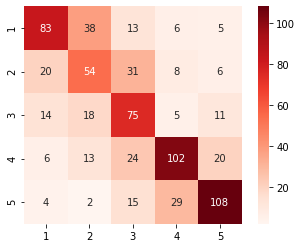

In [30]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, preds, labels= np.sort(reviews_df.Rating.unique()))
cm

sns.heatmap(cm, square= True, annot= True, fmt= 'd', cbar= True, cmap= "Reds", 
            xticklabels= np.sort(reviews_df.Rating.unique()), yticklabels= np.sort(reviews_df.Rating.unique()))
plt.savefig("images/rating_matrix.png")
plt.show()

As we can see, this model is fairly accurate at predicting 1-star and 5-star reviews, but things in between are much more vague (though, interestingly, it's pretty good with 3-star reviews as well). This suggests that there is a good deal of overlap in terms of vocabulary between 2-, 3-, and 4-star reviews.

So while classification might not work to predict review score, we may have more success with using sentiment analysis to analyze those mid-score reviews. A rudimentary way of doing this would be to train and test a classifier with our 1- and 5-star reviews (operating under the assumption that they will be strongly negative and strongly positive, respectively) that will then classify the mid-score reviews as either positive or negative.

In [31]:
def get_tops(vectorizer, clf, class_labels):
    """retrieves features with the highest coefficient values, per class"""
    feat_dict = {}
    feature_names = vectorizer.get_feature_names()
    for i, class_label in enumerate(class_labels):
        top = np.argsort(clf.coef_[i])
        feat_dict[class_label] = [feature_names[j] for j in top]
    return feat_dict

In [32]:
# A look at some of our lexical features

reviewVzer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2), max_df=0.5, min_df=2, stop_words="english")
x_train_tfidf = reviewVzer.fit_transform(x_train)

clf = MultinomialNB(alpha=0.1)
clf.fit(x_train_tfidf, y_train)

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

In [33]:
top_feats = get_tops(reviewVzer, clf, clf.classes_)

for i in top_feats.keys():
    print(f'{i}:', " | ".join(top_feats[i][:10]))

1: snail | strong does | book knew | strong characters | wither | wither deep | strokes | hiker | book introduced | office
2: hugely | boundaries | little predictable | little boy | literary world | truly believe | fan art | tamlins | fangs | lit
3: keys | oh great | styles | brotherhood | fun watch | broad | bring darkness | fundamentally good | funniest | funny book
4: landscapes | baseball | way written | second thought | mr tumnus | basic plot | time story | realising | steer | incorporated
5: zombie | stereotypical | milk | grated | stockholm | centric | mile away | gratuitous | stockholm syndrome | stopped reading


### Linear Regression Analysis

In [34]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

x_test_tfidf = reviewVzer.transform(x_test)

reg = LinearRegression(normalize=False)
reg.fit(x_train_tfidf, y_train)
train_preds = reg.predict(x_train_tfidf)
test_preds = reg.predict(x_test_tfidf)
print("Validation scores...")
print("\tR2:", r2_score(y_train, train_preds))
print("\tMSE:", mean_squared_error(y_train, train_preds))

print("Test scores...")
print("\tR2:", r2_score(y_test, test_preds))
print("\tMSE:", mean_squared_error(y_test, test_preds))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Validation scores...
	R2: 0.999999999999896
	MSE: 2.0870514805123758e-13
Test scores...
	R2: 0.5474522790319131
	MSE: 0.9488833166394854


Although the linear regressor is very well fit to its training data, it doesn't generalize very well when applied to the testing set. it only captures about 56% of the variation in the test set, and the MSE goes up considerably. Ultimately, it seems to be a bit overfit to the training set.

### (TEST) Predicting Score w/ Lemmas

In [35]:
copy_df = reviews_df.copy()

copy_df['Lemmas'] = copy_df.Spacy.map(lambda s: [tok.lemma_ for tok in s])

copy_df.head()

,Year,Genres,Rating,Likes,Date,Shelves,Text,Spacy,Toks,Types,TTR,Lemmas
Title,,,,,,,,,,,,
A Court of Thorns and Roses,2015,"['Fantasy', 'Romance', 'Young Adult', 'New Adu...",1,274,2018-03-26,"['fantasy', 'cover-porn', 'retelling', '1-star...","Me to Sarah J Maas:""Do you lie awake at night ...","(Me, to, Sarah, J, Maas:""Do, you, lie, awake, ...",1810,680,0.375691,"[I, to, Sarah, J, Maas:""Do, you, lie, awake, a..."
A Court of Thorns and Roses,2015,"['Fantasy', 'Romance', 'Young Adult', 'New Adu...",1,198,2019-03-14,[],"""Swift as lightning, he lashed out, grabbing t...","("", Swift, as, lightning, ,, he, lashed, out, ...",1665,673,0.404204,"["", swift, as, lightning, ,, he, lash, out, ,,..."
A Court of Thorns and Roses,2015,"['Fantasy', 'Romance', 'Young Adult', 'New Adu...",1,139,2015-05-20,[],I have a hard time rating this book because of...,"(I, have, a, hard, time, rating, this, book, b...",914,343,0.375274,"[I, have, a, hard, time, rate, this, book, bec..."
A Court of Thorns and Roses,2015,"['Fantasy', 'Romance', 'Young Adult', 'New Adu...",1,140,2019-10-18,[],Imagine being this het being this heterosexu ...,"(Imagine, being, this, het, , being, this, he...",14,11,0.785714,"[imagine, be, this, het, , be, this, heterose..."
A Court of Thorns and Roses,2015,"['Fantasy', 'Romance', 'Young Adult', 'New Adu...",1,128,2017-05-10,"['fantasy', 'ya', 'très-boring', 'reviewed']",Feed pressure is real.I swear Maas' protagonis...,"(Feed, pressure, is, real, ., I, swear, Maas, ...",138,106,0.768116,"[feed, pressure, be, real, ., I, swear, Maas, ..."


In [36]:
# First, we'll redo our classifier...

x_train, x_test, y_train, y_test = train_test_split(copy_df.Lemmas, copy_df.Rating, 
                                                    test_size = 0.20, random_state = 0)

reviewVzer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2), max_df=0.5, min_df=2, stop_words="english")

x_train_lemma = reviewVzer.fit_transform([' '.join(lems) for lems in x_train])
x_test_lemma = reviewVzer.transform([' '.join(lems) for lems in x_test])

clf = MultinomialNB(alpha = 0.1)
clf.fit(x_train_lemma, y_train)

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

0.5845070422535211

array([[ 86,  33,  11,   4,  11],
       [ 20,  56,  25,  14,   4],
       [ 12,  20,  71,  11,   9],
       [  7,  13,  26,  93,  26],
       [  3,   2,  16,  28, 109]])

<AxesSubplot:>

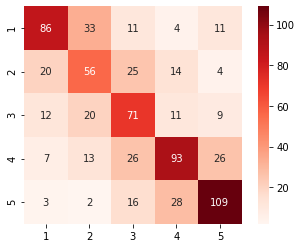

In [37]:
lemma_pred = clf.predict(x_test_lemma)
sklearn.metrics.accuracy_score(y_test, lemma_pred)

cm = confusion_matrix(y_test, lemma_pred, labels= np.sort(reviews_df.Rating.unique()))
cm

sns.heatmap(cm, square= True, annot= True, fmt= 'd', cbar= True, cmap= "Reds", 
            xticklabels= np.sort(reviews_df.Rating.unique()), yticklabels= np.sort(reviews_df.Rating.unique()))
# plt.savefig("images/rating_matrix.png")
plt.show()

In [38]:
# Then, we'll try lemmas in the linear regressor...

reg = LinearRegression(normalize=False)
reg.fit(x_train_lemma, y_train)
train_preds = reg.predict(x_train_lemma)
test_preds = reg.predict(x_test_lemma)
print("Validation scores...")
print("\tR2:", r2_score(y_train, train_preds))
print("\tMSE:", mean_squared_error(y_train, train_preds))

print("Test scores...")
print("\tR2:", r2_score(y_test, test_preds))
print("\tMSE:", mean_squared_error(y_test, test_preds))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Validation scores...
	R2: 0.9999999999998885
	MSE: 2.2353159416751474e-13
Test scores...
	R2: 0.50976148274014
	MSE: 1.027911817137984


Interestingly, using word lemmas seems to boost the accuracy of the classifier slightly, but brings down the R2 value of the regressor

## Part 4: Binary Sentiment Analysis

In [39]:
# For plotting confuison matrices...

def matrixplotter(y_test, preds, classes, name):
    cm = confusion_matrix(y_test, preds)
    cm

    sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=True, cmap="Reds", 
                xticklabels=classes, yticklabels=classes)
    plt.savefig(f"images/{name}.png")
    plt.show()

In [40]:
# For retrieving sorted features...

def binaryfeats(clf):
    top = np.argsort(clf.coef_[0])
    feat_names = reviewVzer.get_feature_names()
    sorted_feats = [(feat_names[t], float(clf.coef_[0][t])) for t in top]
    return sorted_feats

In [41]:
# Split our data between 1 & 5 star reviews and everything else...

low_high_df = reviews_df[reviews_df.Rating.isin([1, 5])].copy()

mid_df = reviews_df[reviews_df.Rating.isin([2, 3, 4])].copy()

In [42]:
low_high_df.info()

mid_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1442 entries, A Court of Thorns and Roses to Uprooted
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Year     1442 non-null   int64  
 1   Genres   1442 non-null   object 
 2   Rating   1442 non-null   int64  
 3   Likes    1442 non-null   int64  
 4   Date     1442 non-null   object 
 5   Shelves  1442 non-null   object 
 6   Text     1442 non-null   object 
 7   Spacy    1442 non-null   object 
 8   Toks     1442 non-null   int64  
 9   Types    1442 non-null   int64  
 10  TTR      1442 non-null   float64
dtypes: float64(1), int64(5), object(5)
memory usage: 135.2+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 2107 entries, A Court of Thorns and Roses to Uprooted
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Year     2107 non-null   int64  
 1   Genres   2107 non-null   object 
 2   Rating   2107 non-nul

In [191]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(low_high_df.Text, low_high_df.Rating, 
                                                    test_size = 0.20, random_state = 0)

reviewVzer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2), max_df=0.5, min_df=2, stop_words="english")
x_train_tfidf = reviewVzer.fit_transform(x_train)
x_test_tfidf = reviewVzer.transform(x_test)

### MultinomialNB

In [193]:
sweight = compute_sample_weight('balanced', y_train)

nb_clf = MultinomialNB()
nb_clf.fit(x_train_tfidf, y_train, sweight)

y_pred = nb_clf.predict(x_test_tfidf)
sklearn.metrics.accuracy_score(y_test, y_pred)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

0.8961937716262975

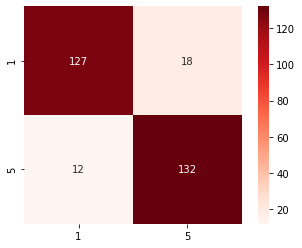

In [194]:
matrixplotter(y_test, y_pred, low_high_df.Rating.unique(), "nb_clf")

In [220]:
nb_feats = binaryfeats(nb_clf)
[feat for (feat, coef) in nb_feats[:25]] # Most negative
[feat for (feat, coef) in nb_feats[-25:]][::-1] # Most positive

['beast retelling', 'unsympathetic clod', 'body parts', 'silent gondoliers', 'bodily fluids', 'signs', 'cue tired', 'cue series', 'fascinating answers', 'fare', 'sidekick', 'sickening', 'cheap shelf', 'showed way', 'offensive', 'short neverwhere', 'update finally', 'fawning', 'feeling supposed', 'sickening reinforcement', 'feels betrayed', 'unsympathetic', 'makes wonder', 'fantasy hero', 'fantasy included']

['story', 'world', 'love', 'time', 'books', 'characters', 'fantasy', 'really', 'reading', 'series', 'loved', 'good', 'think', 'magic', 'review', 'know', 'movie', 'things', 'way', 'people', 'favorite', 'great', 'life', 'novel', 'want']

Interestingly, unigrams seem to dominate the positive list while bigrams dominate the negative. Let's view them seperately...

In [223]:
nb_ugrams = []
for feat in nb_feats:
    if ' ' not in feat[0]:
        nb_ugrams.append(feat)

[feat for (feat, coef) in nb_ugrams[:25]] # Most negative
[feat for (feat, coef) in nb_ugrams[-25:]][::-1] # Most positive

['signs', 'fare', 'sidekick', 'sickening', 'offensive', 'fawning', 'unsympathetic', 'boo', 'unresolved', 'uppity', 'shackles', 'merit', 'sexually', 'urgency', 'offense', 'mystifies', 'fest', 'fictionpress', 'bitchiness', 'site', 'fanfiction', 'exerts', 'manly', 'pejorative', 'oriented']

['story', 'world', 'love', 'time', 'books', 'characters', 'fantasy', 'really', 'reading', 'series', 'loved', 'good', 'think', 'magic', 'review', 'know', 'movie', 'things', 'way', 'people', 'favorite', 'great', 'life', 'novel', 'want']

In [235]:
nb_bgrams = []
for feat in nb_feats:
    if ' ' in feat[0]:
        feat = list(feat)
        feat[0] = feat[0].replace(' ','-')
        nb_bgrams.append(tuple(feat)) 

[feat for (feat, coef) in nb_bgrams[:25]] # Most negative
[feat for (feat, coef) in nb_bgrams[-25:]][::-1] # Most positive

['beast-retelling', 'unsympathetic-clod', 'body-parts', 'silent-gondoliers', 'bodily-fluids', 'cue-tired', 'cue-series', 'fascinating-answers', 'cheap-shelf', 'showed-way', 'short-neverwhere', 'update-finally', 'feeling-supposed', 'sickening-reinforcement', 'feels-betrayed', 'makes-wonder', 'fantasy-hero', 'fantasy-included', 'time-picturing', 'fantasy-lover', 'fantasy-martin', 'simply-satisfying', 'offensive-protagonist', 'simply-help', 'tale-lauded']

['read-book', 'neil-gaiman', 'world-building', 'lord-rings', 've-read', 'harry-potter', 'reading-book', 'loved-book', 'terry-pratchett', 'book-like', 'year-old', 'middle-earth', 'wizard-earthsea', 'fairy-tale', 'second-time', 'wheel-time', 'really-enjoyed', 'favorite-books', 'don-know', 'good-evil', 'love-book', 'night-circus', 'game-thrones', 'feel-like', 'writing-style']

This classifier seems to work pretty well as a baseline. Let's see how it compares to some other methods...

(Note that, for now, these reviews are labeled as 1 for negative and 5 for positive. I will change this to 'neg' and 'pos' later.)

### Grid Search + LogisticRegression

In [49]:
# As this is predicting only two classes, we'll use logistic regression this time around...

from sklearn.linear_model import LogisticRegression

gridlr_clf = LogisticRegression()
Vzer = TfidfVectorizer(max_df=0.5, min_df=2, stop_words="english")
pipe = Pipeline([('tfidf', Vzer), ('clf',gridlr_clf)])

param_grid = {
    # 'clf__penalty': ['l1', 'l2'],                     
    # 'clf__C': [0.001, 0.01, 1, 100, 1000],
    'clf__class_weight': [None, 'balanced'],
    'tfidf__max_features': [5000, 10000],
    'tfidf__ngram_range': [(1,1),(1,2),(2,2)]
}

grid_search = GridSearchCV(pipe, param_grid, cv=5, verbose=1)
grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   56.4s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('tfidf',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=0.5,
                                                        max_features=None,
                                                        min_df=2,
                                                        ngram_range=(1, 1),
                                                        n

In [50]:
grid_search.best_score_
grid_search.best_params_

0.9132618106531151

{'clf__class_weight': 'balanced', 'tfidf__max_features': 10000, 'tfidf__ngram_range': (1, 2)}

In [51]:
preds = grid_search.predict(x_test)
sklearn.metrics.accuracy_score(y_test, preds)

0.8927335640138409

This model generalizes fairly well, but is perhaps a touch overfit

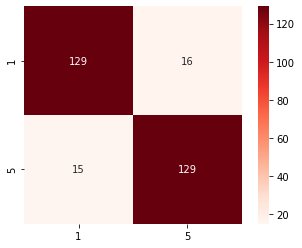

In [52]:
preds = grid_search.predict(x_test)

matrixplotter(y_test, preds, low_high_df.Rating.unique(), 'gridlr_clf')

In [53]:
# Train a new classifier with the ideal paramaters. This is the only way to actually look at top features.

gridlr_clf = LogisticRegression(class_weight=None).fit(x_train_tfidf, y_train)

In [54]:
gridlr_feats = binaryfeats(gridlr_clf)
[feat for (feat, coef) in gridlr_feats[:20]] # Most negative
[feat for (feat, coef) in gridlr_feats[-20:]] # Most positive

['boring', 'didn', 'pages', 'couldn', 'plot', 'author', 'bad', 'star', 'dnf', 'character', 'writing', 'hate', 'don', 'main', 'finish', 'dull', 'reason', 'care', 'supposed', 'hated']

['dark', 'edition', 'stars', 'life', 'perfect', 'magic', 'adventure', 'movie', 'favourite', 'blog', 'wonderful', 'wait', 'great', 'review', 'time', 'reread', 'world', 'love', 'favorite', 'loved']

These feature lists generally make a lot of sense for both positive and negative reviews. It is interesting that 'dark' would be so closely associated with positive reviews (possibly reflective of that trend a few years back of making everything as dark and gritty as possible), but other than that, it looks great!

###  LSA + SVC

In [55]:
from sklearn.decomposition import TruncatedSVD
from sklearn.svm import LinearSVC

svc_clf = LinearSVC()
svd = TruncatedSVD(n_components=1000)
svc_pipe = Pipeline([('svd', svd), ('clf',svc_clf)])
svc_pipe.fit(x_train_tfidf, y_train)

y_pred = svc_pipe.predict(x_test_tfidf)
sklearn.metrics.accuracy_score(y_test, y_pred)

Pipeline(memory=None,
         steps=[('svd',
                 TruncatedSVD(algorithm='randomized', n_components=1000,
                              n_iter=5, random_state=None, tol=0.0)),
                ('clf',
                 LinearSVC(C=1.0, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
                           loss='squared_hinge', max_iter=1000,
                           multi_class='ovr', penalty='l2', random_state=None,
                           tol=0.0001, verbose=0))],
         verbose=False)

0.916955017301038

*Yeehaw*

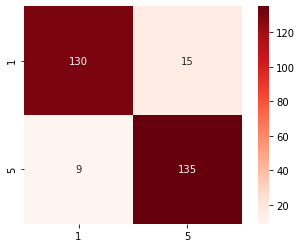

In [56]:
matrixplotter(y_test, y_pred, low_high_df.Rating.unique(), "svc_clf")

In [57]:
# NOTE: Because we ran dimensionality-reduction first, the features came out a little wonky. As such, this is not a
# particularly helpful bit of analysis...

svc_feats = binaryfeats(svc_clf)
[feat for (feat, coef) in svc_feats[:20]] # Most negative
[feat for (feat, coef) in svc_feats[-20:]] # Most positive

['1000', '100 pages', '10', '15', '1937', '24', '17 year', '21st century', 'absorbed', '1977', 'abound', 'best way', 'add', 'archive', '50', 'aes sedai', 'apocalypse', 'announce end', 'assassin', '20']

['100', '1382', '101', '700 pages', '10th', 'actors', 'abilities', 'absolutely hated', '19', '2007', '1954', 'actually read', 'acclaimed', '150 pages', '12 year', '1381', '11', '181', '12 000', '13']

---

SVC seems to just barely edge out LogisticRegression and MultinomialNB in classifying our reviews. Unfortunately, because we ran dimensionality-reduction, it doesn't play nice with our feature extractor function. Similarly, trying to extract features from a cross-validated set is a hassle. Thus, for the wordclouds we will use MultinomialNB, but for classifying mid_df, we will use the LinearSVC

In [124]:
mid_tfidf = reviewVzer.transform(mid_df.Text)
pred = svc_pipe.predict(mid_tfidf)
mid_df['Sentiment'] = pred
mid_df.sample(10)

,Year,Genres,Rating,Likes,Date,Shelves,Text,Spacy,Toks,Types,TTR,Sentiment
Title,,,,,,,,,,,,
Eragon,2002,"['Fantasy', 'Young Adult', 'Fiction', 'Fantasy...",3,12,2018-09-02,[],"Id like to give this book a proper review, bec...","(I, d, like, to, give, this, book, a, proper, ...",182,110,0.604396,5
The Lies of Locke Lamora,2006,"['Fantasy', 'Fiction', 'Adventure', 'Adult', '...",4,123,2012-03-22,[],"Hello, distinguished review reader. What a nic...","(Hello, ,, distinguished, review, reader, ., W...",453,221,0.487859,5
The Eye of the World,1990,"['Fantasy', 'Fiction', 'Fantasy', 'Epic Fantas...",2,18,2020-07-30,['dudebro-reading-challenge'],"Oh merciful gods, I am finally done with book ...","(Oh, merciful, gods, ,, I, am, finally, done, ...",891,403,0.452301,5
American Gods,2001,"['Fantasy', 'Fiction', 'Fantasy', 'Urban Fanta...",4,135,2012-02-07,"['secret-histories', 'legendarium']","a protagonist, Shadow. calm, collected, quiet,...","(a, protagonist, ,, Shadow, ., calm, ,, collec...",825,390,0.472727,5
Throne of Glass,2012,"['Fantasy', 'Young Adult', 'Romance', 'Fiction...",4,146,2016-05-31,"['21th-century', 'romance', 'young-adult', 'fi...","Throne of Glass (Throne of Glass #1), Sarah J....","(Throne, of, Glass, (, Throne, of, Glass, #, 1...",184,102,0.554348,1
Twilight,2005,"['Young Adult', 'Fantasy', 'Romance', 'Fiction...",3,38,2013-01-05,[],First rating in 2008: 5 Rating 2019: 3 I cant ...,"(First, rating, in, 2008, :, 5, Rating, 2019, ...",180,107,0.594444,5
Graceling,2008,"['Fantasy', 'Young Adult', 'Romance', 'Fiction...",3,122,2008-07-30,"['ya-books', 'fantasy']",[This is a review of an advance copy.:]While C...,"([, This, is, a, review, of, an, advance, copy...",198,131,0.661616,1
The Color of Magic,1983,"['Fantasy', 'Fiction', 'Humor', 'Humor', 'Come...",4,240,2012-10-21,"['make-me-laugh', '2013-reads', 'fantasy']",Reading The Color of Magic is akin to eating a...,"(Reading, The, Color, of, Magic, is, akin, to,...",956,430,0.449791,5
The Name of the Wind,2007,"['Fantasy', 'Fiction', 'Fantasy', 'Epic Fantas...",4,45,2019-04-27,[],Rothfuss' first day into the world of Kvothe a...,"(Rothfuss, ', first, day, into, the, world, of...",128,88,0.687500,1


In [241]:
print('2-star reviews...')
print(mid_df[mid_df.Rating== 2].Sentiment.value_counts())
print()
print('3-star reviews...')
print(mid_df[mid_df.Rating== 3].Sentiment.value_counts())
print()
print('4-star reviews...')
print(mid_df[mid_df.Rating== 4].Sentiment.value_counts())

2-star reviews...
1    560
5    123
Name: Sentiment, dtype: int64

3-star reviews...
5    346
1    337
Name: Sentiment, dtype: int64

4-star reviews...
5    585
1    156
Name: Sentiment, dtype: int64


Perhaps it shouldn't be surprising that 2-star reviews are more negative and 4-star reviews more positive with 3-star reviews almost equal, but it is interesting that there are still some 'negative' 4-star and 'positive' 1-star reviews.

In [126]:
mid_df.groupby(['Rating','Sentiment']).Toks.mean()

Rating  Sentiment
2       1            497.453571
        5            498.569106
3       1            495.462908
        5            461.193642
4       1            423.044872
        5            557.234188
Name: Toks, dtype: float64

And it doesn't seem like the out-of-place reviews are significantly shorter or longer either, meaning this probably is not a case of short/long reviews being classified a certain way.

In [127]:
low_high_df["Sentiment"] = low_high_df.Rating

sentiment_df = pd.concat([low_high_df, mid_df]).sort_index()
sentiment_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3549 entries, A Court of Thorns and Roses to Uprooted
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Year       3549 non-null   int64  
 1   Genres     3549 non-null   object 
 2   Rating     3549 non-null   int64  
 3   Likes      3549 non-null   int64  
 4   Date       3549 non-null   object 
 5   Shelves    3549 non-null   object 
 6   Text       3549 non-null   object 
 7   Spacy      3549 non-null   object 
 8   Toks       3549 non-null   int64  
 9   Types      3549 non-null   int64  
 10  TTR        3549 non-null   float64
 11  Sentiment  3549 non-null   int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 360.4+ KB


In [128]:
# Let's finally give those sentiment ratings the tags they deserve...

def sentiment_tagger(sent):
    if sent == 5: return 'pos'
    if sent == 1: return 'neg'

sentiment_df.Sentiment = sentiment_df.Sentiment.map(sentiment_tagger)
sentiment_df.head()

,Year,Genres,Rating,Likes,Date,Shelves,Text,Spacy,Toks,Types,TTR,Sentiment
Title,,,,,,,,,,,,
A Court of Thorns and Roses,2015,"['Fantasy', 'Romance', 'Young Adult', 'New Adu...",1,274,2018-03-26,"['fantasy', 'cover-porn', 'retelling', '1-star...","Me to Sarah J Maas:""Do you lie awake at night ...","(Me, to, Sarah, J, Maas:""Do, you, lie, awake, ...",1810,680,0.375691,neg
A Court of Thorns and Roses,2015,"['Fantasy', 'Romance', 'Young Adult', 'New Adu...",3,103,2015-04-25,"['book-boyfriend-material', 'buddy-read', 'fan...",Kindle deal for a limited time 19May19 $1.99Be...,"(Kindle, deal, for, a, limited, time, 19May19,...",1597,576,0.360676,pos
A Court of Thorns and Roses,2015,"['Fantasy', 'Romance', 'Young Adult', 'New Adu...",3,109,2018-07-03,['fantasy'],"*i deleted my previous review, because i did n...","(*, i, deleted, my, previous, review, ,, becau...",710,304,0.428169,neg
A Court of Thorns and Roses,2015,"['Fantasy', 'Romance', 'Young Adult', 'New Adu...",3,113,2018-01-14,"['romance', 'ya-fantasy', 'young-adult', 'new-...","3.75/5 starsMay I just say, that if you are pl...","(3.75/5, starsMay, I, just, say, ,, that, if, ...",1479,553,0.373901,neg
A Court of Thorns and Roses,2015,"['Fantasy', 'Romance', 'Young Adult', 'New Adu...",3,92,2014-10-31,"['fairytale', 'read-in-2015', 'retelling']",3.5 starsHere's the thing: I went into this wi...,"(3.5, starsHere, 's, the, thing, :, I, went, i...",675,301,0.445926,neg


In [129]:
sentiment_df.Sentiment.value_counts()

pos    1802
neg    1747
Name: Sentiment, dtype: int64

### Likes / Rating Correlation: A detour
- Hypothesis will be that more positive reviews have more likes. As mentionned previously, all of the books used were over-all very positively received. Thus, positive reviews should resonate more and should therefore have more likes on average

In [130]:
mid_df.groupby('Sentiment').Likes.mean()

Sentiment
1    149.626781
5    157.118596
Name: Likes, dtype: float64

In [131]:
from scipy.stats import ttest_ind

pos_likes = mid_df[mid_df.Sentiment==5].Likes
neg_likes = mid_df[mid_df.Sentiment==1].Likes

t, p = ttest_ind(pos_likes, neg_likes, equal_var=False)
print(f"ttest_ind:\tt = {t}  p = {p}")

ttest_ind:	t = 0.6120927198871491  p = 0.5405588129613939


Positive reviews do seem to have more likes on average, but it's not quite as big a difference as I expected. However, the p-value from the t-test is significant, indicating that they are likely not from the same underlaying population. Now let's see if likes and specific scores are correlated

Unfortunately, there's no easy way to test correlation between a continuous variable (likes) and a categorical variable of five levels (rating). So instead, since this isn't really a stats course, we'll just eyeball it and call it a day...

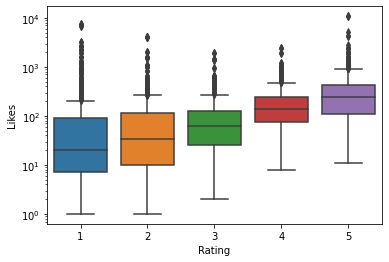

In [132]:
sns.boxplot(x='Rating', y='Likes', data=reviews_df).set_yscale('log')
plt.savefig("images/ratings_likes.png")
plt.show()

<AxesSubplot:ylabel='Density'>

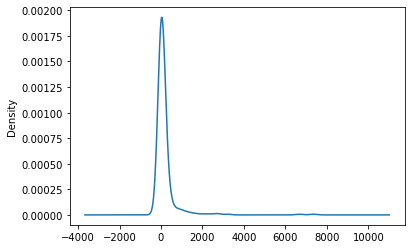

<AxesSubplot:ylabel='Density'>

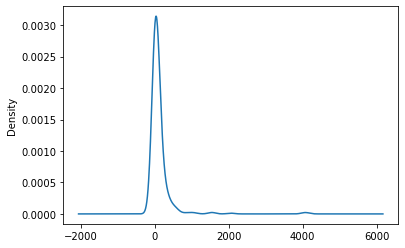

<AxesSubplot:ylabel='Density'>

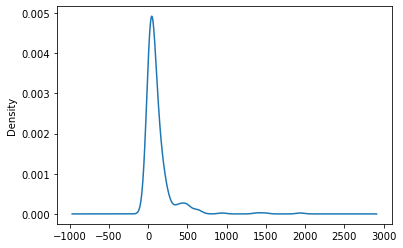

<AxesSubplot:ylabel='Density'>

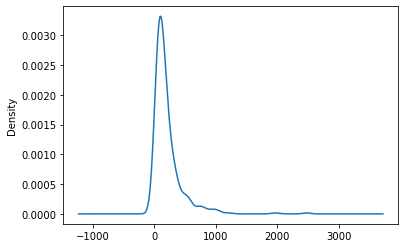

<AxesSubplot:ylabel='Density'>

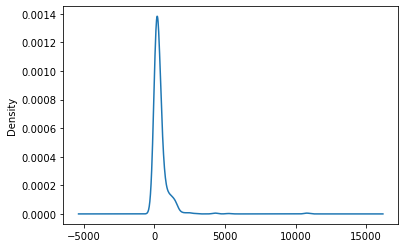

In [133]:
score_groups = reviews_df.groupby('Rating')
for s in score_groups:
    s[1].Likes.plot(kind='density')
    plt.savefig(f"images/density{s[0]}.png")
    plt.show()

The distributions are skewed slightly positive, so an ANoVA wouldn't be super helpful

In [134]:
# Run t-tests for each combination of the rating group populations...

from scipy.stats import f_oneway
from itertools import combinations

reviewgroups = reviews_df.groupby('Rating')

# ANoVA for all groups
# f_oneway(reviewgroups.get_group(1).Likes, reviewgroups.get_group(2).Likes, reviewgroups.get_group(3).Likes, reviewgroups.get_group(4).Likes, reviewgroups.get_group(5).Likes)

# T-Test for each combination of scores
for x, y in combinations(range(1,6), r=2):       
    t, p = ttest_ind(reviewgroups.get_group(x).Likes, reviewgroups.get_group(y).Likes, equal_var=False)
    print(f"ttest group {x}, {y}:\tt = {t}  p = {p}")

ttest group 1, 2:	t = 1.9977404771769411  p = 0.045990193466418756
ttest group 1, 3:	t = 2.54511713452734  p = 0.011106940802698004
ttest group 1, 4:	t = -0.9996179250210906  p = 0.3177713369495338
ttest group 1, 5:	t = -6.1503077619667605  p = 1.0001057995348845e-09
ttest group 2, 3:	t = 0.5481096894101017  p = 0.5837353495696032
ttest group 2, 4:	t = -4.950595170836847  p = 8.481162771906305e-07
ttest group 2, 5:	t = -9.324748000581797  p = 5.619892970338883e-20
ttest group 3, 4:	t = -7.860748276294623  p = 7.60742553075336e-15
ttest group 3, 5:	t = -10.508416965981285  p = 2.172394689166817e-24
ttest group 4, 5:	t = -7.028150978228733  p = 4.0736188409419986e-12


The t-tests show that the differences between almost all of the populations are statistically significant. The main exceptions seem to be between 1 & 4 star reviews and 2 & 3 star reviews.

## Wordclouds

In [236]:
# Generate word clouds from gridlr_feats
# NOTE: The method .generate_from_frequencies() requires a dict object to map words to custom frequencies. For a 
# simpler method, apply .generate() to any text and it will create a wordcloud based on each word's frequency
# within the text (removes stopwords by default)

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

pos_feats = dict((f[0], float(f[1])) for f in nb_feats)
pos_cloud = WordCloud().generate_from_frequencies(pos_feats)
pos_cloud.to_file("images/pos_cloud.png")

neg_feats = dict((f[0], -float(f[1])) for f in nb_feats)
neg_cloud = WordCloud().generate_from_frequencies(neg_feats)
neg_cloud.to_file("images/neg_cloud.png")

pos_bgrams = dict((f[0], float(f[1])) for f in nb_bgrams)
pos_bgram_cloud = WordCloud().generate_from_frequencies(pos_bgrams)
pos_bgram_cloud.to_file("images/pos_bgram_cloud.png")

neg_bgrams = dict((f[0], -float(f[1])) for f in nb_bgrams)
neg_bgram_cloud = WordCloud().generate_from_frequencies(neg_bgrams)
neg_bgram_cloud.to_file("images/neg_bgram_cloud.png")

pos_ugrams = dict((f[0], float(f[1])) for f in nb_ugrams)
pos_ugram_cloud = WordCloud().generate_from_frequencies(pos_ugrams)
pos_ugram_cloud.to_file("images/pos_ugram_cloud.png")

neg_ugrams = dict((f[0], -float(f[1])) for f in nb_ugrams)
neg_ugram_cloud = WordCloud().generate_from_frequencies(neg_ugrams)
neg_ugram_cloud.to_file("images/neg_ugram_cloud.png")

---

## Part 5: Lexical Analysis w/ SpaCy

In [136]:
# Split sentiment_df into positive and negative dataframes...

pos_df = sentiment_df[sentiment_df.Sentiment == 'pos']
neg_df = sentiment_df[sentiment_df.Sentiment == 'neg']

In [137]:
# Examine token counts and likes by sentiment...

print(f"Token counts by sentiment...\nPos:\t{pos_df.Toks.mean()}\nNeg:\t{neg_df.Toks.mean()}")
print()
print(f"Likes by sentiment...\nPos:\t{pos_df.Likes.mean()}\nNeg:\t{neg_df.Likes.mean()}")

Token counts by sentiment...
Pos:	543.0238623751387
Neg:	484.66170578133944

Likes by sentiment...
Pos:	259.9866814650388
Neg:	163.1648540354894


Both token count and likes seem to be a good bit higher on average in positive reviews, confirming what we could not by just looking at review score...

### Part of Speech

In [138]:
# Count part of speech frequency in positive and negative reviews...

from collections import Counter

pos_parts = Counter()
for text in pos_df.Spacy:
    for tok in text:
        pos_parts.update([tok.pos_])

neg_parts = Counter()
for text in neg_df.Spacy:
    for tok in text:
        neg_parts.update([tok.pos_])

In [139]:
# In order to make more accurate comparisons, we convert the counts into relative frequencies...

pos_parts_total = sum(pos_parts.values())
neg_parts_total = sum(neg_parts.values())

for k in pos_parts.keys():
    pos_parts[k] = np.round(pos_parts[k]/pos_parts_total, decimals=3)
    
for k in neg_parts.keys():
    neg_parts[k] = np.round(neg_parts[k]/neg_parts_total, decimals=3)
    
pos_parts.most_common()
neg_parts.most_common()

[('NOUN', 0.15), ('PUNCT', 0.122), ('VERB', 0.118), ('DET', 0.1), ('PRON', 0.096), ('ADP', 0.088), ('ADJ', 0.067), ('ADV', 0.063), ('PROPN', 0.049), ('AUX', 0.048), ('CCONJ', 0.038), ('PART', 0.027), ('SCONJ', 0.014), ('NUM', 0.009), ('SPACE', 0.006), ('INTJ', 0.003), ('SYM', 0.001), ('X', 0.001)]

[('NOUN', 0.144), ('VERB', 0.124), ('PUNCT', 0.122), ('PRON', 0.099), ('DET', 0.096), ('ADP', 0.084), ('ADV', 0.069), ('ADJ', 0.068), ('AUX', 0.053), ('PROPN', 0.037), ('CCONJ', 0.036), ('PART', 0.032), ('SCONJ', 0.017), ('NUM', 0.009), ('INTJ', 0.005), ('SPACE', 0.003), ('SYM', 0.001), ('X', 0.001)]

### Pronouns

In [140]:
pos_pron = Counter()
for text in pos_df.Spacy:
    for tok in text:
        if tok.pos_ == 'PRON':
            pos_pron.update([tok.lemma_.lower().strip()])
            
neg_pron = Counter()
for text in neg_df.Spacy:
    for tok in text:
        if tok.pos_ == 'PRON':
            neg_pron.update([tok.lemma_.lower().strip()])

In [141]:
pos_pron_total = sum(pos_pron.values())
neg_pron_total = sum(neg_pron.values())

for k in pos_pron.keys():
    pos_pron[k] = np.round(pos_pron[k]/pos_pron_total, decimals=3)
    
for k in neg_pron.keys():
    neg_pron[k] = np.round(neg_pron[k]/neg_pron_total, decimals=3)

pos_pron.most_common(20)
neg_pron.most_common(20)

[('i', 0.281), ('it', 0.143), ('he', 0.075), ('you', 0.066), ('they', 0.049), ('my', 0.048), ('his', 0.042), ('she', 0.035), ('what', 0.028), ('there', 0.027), ('who', 0.025), ('we', 0.025), ('_', 0.025), ('her', 0.019), ('its', 0.018), ('their', 0.018), ('your', 0.012), ('something', 0.009), ('our', 0.007), ('everything', 0.006)]

[('i', 0.315), ('it', 0.152), ('he', 0.067), ('you', 0.059), ('she', 0.052), ('they', 0.048), ('my', 0.041), ('his', 0.035), ('what', 0.03), ('there', 0.026), ('who', 0.024), ('her', 0.022), ('we', 0.02), ('their', 0.014), ('its', 0.012), ('something', 0.011), ('your', 0.009), ('nothing', 0.008), ('anything', 0.006), ('everything', 0.006)]

In [142]:
i = 1
for pos, neg in zip(pos_pron.most_common(20), neg_pron.most_common(20)):
    print(str(i)+'.)',pos,"\t",neg)
    i+=1

1.) ('i', 0.281) 	 ('i', 0.315)
2.) ('it', 0.143) 	 ('it', 0.152)
3.) ('he', 0.075) 	 ('he', 0.067)
4.) ('you', 0.066) 	 ('you', 0.059)
5.) ('they', 0.049) 	 ('she', 0.052)
6.) ('my', 0.048) 	 ('they', 0.048)
7.) ('his', 0.042) 	 ('my', 0.041)
8.) ('she', 0.035) 	 ('his', 0.035)
9.) ('what', 0.028) 	 ('what', 0.03)
10.) ('there', 0.027) 	 ('there', 0.026)
11.) ('who', 0.025) 	 ('who', 0.024)
12.) ('we', 0.025) 	 ('her', 0.022)
13.) ('_', 0.025) 	 ('we', 0.02)
14.) ('her', 0.019) 	 ('their', 0.014)
15.) ('its', 0.018) 	 ('its', 0.012)
16.) ('their', 0.018) 	 ('something', 0.011)
17.) ('your', 0.012) 	 ('your', 0.009)
18.) ('something', 0.009) 	 ('nothing', 0.008)
19.) ('our', 0.007) 	 ('anything', 0.006)
20.) ('everything', 0.006) 	 ('everything', 0.006)


To get a more accurate reading on pronouns, I organized them by lemma rather than by raw text. What we can see is that these lists are surprisingly similar. The big difference that stands out to me is that "i" seems to be a bit more frequent in negative reviews (0.318) compared to positive reviews (0.279). Also, feminine pronouns are a bit more frequent overall in the negative reviews while masculine pronouns are conversely less frequent. 

Overall, the difference in first-person pronouns use between positive and negative reviews is small but noticeable. It supports the hypothesis that negative reviews focus more on personal experience. What is perhaps more interesting is the difference between masculine and feminine pronouns between the two categories. It hints at a trend but is not quite conclusive. Later on, in the section title Titular Analysis, we will go a bit more in-depth to see if specific books are more associated with masculine or feminine pronouns, and whether that has an effect on review sentiment.

<BarContainer object of 20 artists>

([<matplotlib.axis.XTick object at 0x18deadaf0>, <matplotlib.axis.XTick object at 0x18deadac0>, <matplotlib.axis.XTick object at 0x1916ebc10>, <matplotlib.axis.XTick object at 0x18d414b50>, <matplotlib.axis.XTick object at 0x19a619370>, <matplotlib.axis.XTick object at 0x19a619ac0>, <matplotlib.axis.XTick object at 0x19a61d250>, <matplotlib.axis.XTick object at 0x19a61d9a0>, <matplotlib.axis.XTick object at 0x19a624130>, <matplotlib.axis.XTick object at 0x19a61d430>, <matplotlib.axis.XTick object at 0x18d414eb0>, <matplotlib.axis.XTick object at 0x19a624640>, <matplotlib.axis.XTick object at 0x19a624d90>, <matplotlib.axis.XTick object at 0x19a69d520>, <matplotlib.axis.XTick object at 0x19a69dc70>, <matplotlib.axis.XTick object at 0x19a6a3400>, <matplotlib.axis.XTick object at 0x19a69d460>, <matplotlib.axis.XTick object at 0x18d414a90>, <matplotlib.axis.XTick object at 0x19a6a30d0>, <matplotlib.axis.XTick object at 0x19a6a3eb0>], [Text(0, 0, 'i'), Text(1, 0, 'it'), Text(2, 0, 'he'), Tex

Text(0, 0.5, 'Relative Frequency')

Text(0.5, 1.0, 'Frequency of Pronouns (positive)')

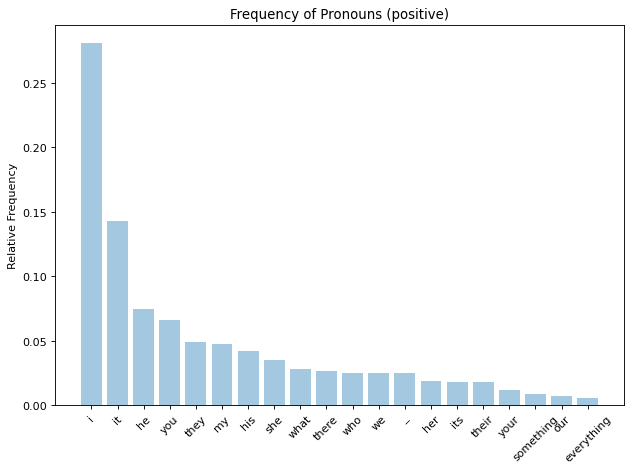

In [143]:
from matplotlib.pyplot import figure

keys = [key for (key, value) in pos_pron.most_common(20)]
x_pos = np.arange(len(keys))
counts = [pos_pron[k] for k in keys]

fig = figure(figsize=(8, 6), dpi=80)
plt.bar(x_pos, counts, align='center', alpha=0.4)
plt.xticks(x_pos, keys, rotation = 45)
plt.ylabel('Relative Frequency')
plt.title('Frequency of Pronouns (positive)')
plt.tight_layout()
plt.savefig("images/pos_pronouns.png")
plt.show()

<BarContainer object of 20 artists>

([<matplotlib.axis.XTick object at 0x19a70da00>, <matplotlib.axis.XTick object at 0x19a70d9d0>, <matplotlib.axis.XTick object at 0x19a705a30>, <matplotlib.axis.XTick object at 0x19493bb50>, <matplotlib.axis.XTick object at 0x19a1790d0>, <matplotlib.axis.XTick object at 0x19a179760>, <matplotlib.axis.XTick object at 0x19a179eb0>, <matplotlib.axis.XTick object at 0x19a17f640>, <matplotlib.axis.XTick object at 0x19a17fd90>, <matplotlib.axis.XTick object at 0x19a186520>, <matplotlib.axis.XTick object at 0x19a17f820>, <matplotlib.axis.XTick object at 0x19a1797c0>, <matplotlib.axis.XTick object at 0x19a186b50>, <matplotlib.axis.XTick object at 0x19a18d2e0>, <matplotlib.axis.XTick object at 0x19a18da30>, <matplotlib.axis.XTick object at 0x19a1951c0>, <matplotlib.axis.XTick object at 0x19a195910>, <matplotlib.axis.XTick object at 0x19a18d700>, <matplotlib.axis.XTick object at 0x19a179940>, <matplotlib.axis.XTick object at 0x19a1954c0>], [Text(0, 0, 'i'), Text(1, 0, 'it'), Text(2, 0, 'he'), Tex

Text(0, 0.5, 'Relative Frequency')

Text(0.5, 1.0, 'Frequency of Pronouns (negative)')

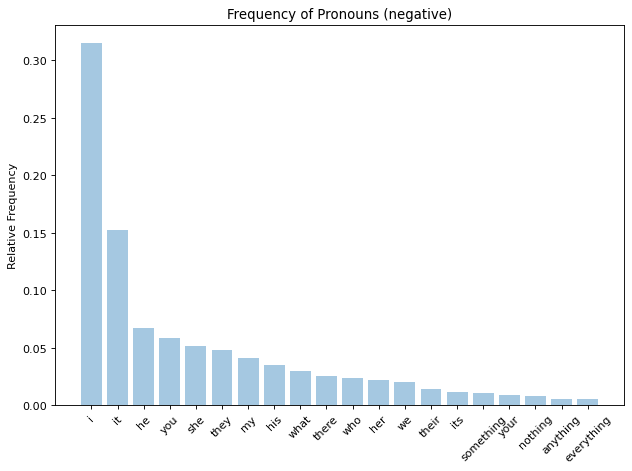

In [144]:
keys = [key for (key, value) in neg_pron.most_common(20)]
x_pos = np.arange(len(keys))
counts = [neg_pron[k] for k in keys]

fig = figure(figsize=(8, 6), dpi=80)
plt.bar(x_pos, counts, align='center', alpha=0.4)
plt.xticks(x_pos, keys, rotation = 45)
plt.ylabel('Relative Frequency')
plt.title('Frequency of Pronouns (negative)')
plt.tight_layout()
plt.savefig("images/neg_pronouns.png")
plt.show()

### Interjections

In [145]:
pos_intj = Counter()
for text in pos_df.Spacy:
    for tok in text:
        if tok.pos_ == 'INTJ':
            pos_intj.update([tok.lemma_.lower().strip()])
            
neg_intj = Counter()
for text in neg_df.Spacy:
    for tok in text:
        if tok.pos_ == 'INTJ':
            neg_intj.update([tok.lemma_.lower().strip()])

In [146]:
pos_intj_total = sum(pos_intj.values())
neg_intj_total = sum(neg_intj.values())

for k in pos_intj.keys():
    pos_intj[k] = np.round(pos_intj[k]/pos_intj_total, decimals=3)

for k in neg_intj.keys():
    neg_intj[k] = np.round(neg_intj[k]/neg_intj_total, decimals=3)

pos_intj.most_common(20)
neg_intj.most_common(20)

[('yes', 0.128), ('well', 0.122), ('like', 0.09), ('oh', 0.088), ('no', 0.078), ('please', 0.043), ('okay', 0.033), ('yeah', 0.032), ('anyway', 0.026), ('sure', 0.023), ('wow', 0.022), ('boy', 0.019), ('hey', 0.018), ('sorry', 0.012), ('ha', 0.01), ('ok', 0.009), ('haha', 0.008), ('um', 0.008), ('ah', 0.008), ('gosh', 0.007)]

[('oh', 0.095), ('well', 0.094), ('no', 0.09), ('like', 0.089), ('yes', 0.08), ('blah', 0.062), ('yeah', 0.045), ('okay', 0.044), ('please', 0.037), ('sure', 0.026), ('hey', 0.021), ('sorry', 0.019), ('ok', 0.019), ('ha', 0.019), ('wow', 0.018), ('anyway', 0.014), ('god', 0.011), ('nope', 0.009), ('right', 0.008), ('boy', 0.007)]

In [147]:
i = 1
for pos, neg in zip(pos_intj.most_common(20), neg_intj.most_common(20)):
    print(str(i)+'.)',pos,"\t",neg)
    i+=1

1.) ('yes', 0.128) 	 ('oh', 0.095)
2.) ('well', 0.122) 	 ('well', 0.094)
3.) ('like', 0.09) 	 ('no', 0.09)
4.) ('oh', 0.088) 	 ('like', 0.089)
5.) ('no', 0.078) 	 ('yes', 0.08)
6.) ('please', 0.043) 	 ('blah', 0.062)
7.) ('okay', 0.033) 	 ('yeah', 0.045)
8.) ('yeah', 0.032) 	 ('okay', 0.044)
9.) ('anyway', 0.026) 	 ('please', 0.037)
10.) ('sure', 0.023) 	 ('sure', 0.026)
11.) ('wow', 0.022) 	 ('hey', 0.021)
12.) ('boy', 0.019) 	 ('sorry', 0.019)
13.) ('hey', 0.018) 	 ('ok', 0.019)
14.) ('sorry', 0.012) 	 ('ha', 0.019)
15.) ('ha', 0.01) 	 ('wow', 0.018)
16.) ('ok', 0.009) 	 ('anyway', 0.014)
17.) ('haha', 0.008) 	 ('god', 0.011)
18.) ('um', 0.008) 	 ('nope', 0.009)
19.) ('ah', 0.008) 	 ('right', 0.008)
20.) ('gosh', 0.007) 	 ('boy', 0.007)


This list mostly matches expectations, I'd say. Positive interjections (yeah, yes) are more common in positive reviews while negative interjections (no, nope) are more frequent in negative ones. Negative reviews also seem to be a bit more sarcastic, with interjections like 'right', 'anyway', and 'boy'.

If I had to pick a favorite here it would be 'blah' in the negative column.

### Punctuation

In [148]:
pos_punct = Counter()
for text in pos_df.Spacy:
    for tok in text:
        if tok.pos_ == 'PUNCT':
            pos_punct.update([tok.lemma_.lower().strip()])
            
neg_punct = Counter()
for text in neg_df.Spacy:
    for tok in text:
        if tok.pos_ == 'PUNCT':
            neg_punct.update([tok.lemma_.lower().strip()])

In [149]:
pos_punct_total = sum(pos_punct.values())
neg_punct_total = sum(neg_punct.values())

for k in pos_punct.keys():
    pos_punct[k] = np.round(pos_punct[k]/pos_punct_total, decimals=3)

for k in neg_punct.keys():
    neg_punct[k] = np.round(neg_punct[k]/neg_punct_total, decimals=3)

pos_punct.most_common(20)
neg_punct.most_common(20)

[(',', 0.378), ('.', 0.351), ('-', 0.048), ('!', 0.035), ('(', 0.03), (':', 0.028), ('"', 0.028), (')', 0.027), ('?', 0.023), ('...', 0.011), (';', 0.011), ('*', 0.01), ("'", 0.005), (']', 0.002), ('--', 0.002), ('..', 0.002), ('[', 0.001), ('....', 0.001), (':)', 0.001), ('=', 0.001)]

[('.', 0.358), (',', 0.354), ('-', 0.05), ('"', 0.039), ('(', 0.035), ('?', 0.034), (')', 0.032), (':', 0.023), ('!', 0.022), ('...', 0.014), ("'", 0.011), (';', 0.008), ('*', 0.006), ('--', 0.004), ('[', 0.002), (']', 0.002), ('..', 0.001), ('/', 0.001), ('....', 0.001), ('movei', 0.0)]

In [150]:
i = 1
for pos, neg in zip(pos_punct.most_common(20), neg_punct.most_common(20)):
    print(str(i)+'.)',pos,"\t",neg)
    i+=1

1.) (',', 0.378) 	 ('.', 0.358)
2.) ('.', 0.351) 	 (',', 0.354)
3.) ('-', 0.048) 	 ('-', 0.05)
4.) ('!', 0.035) 	 ('"', 0.039)
5.) ('(', 0.03) 	 ('(', 0.035)
6.) (':', 0.028) 	 ('?', 0.034)
7.) ('"', 0.028) 	 (')', 0.032)
8.) (')', 0.027) 	 (':', 0.023)
9.) ('?', 0.023) 	 ('!', 0.022)
10.) ('...', 0.011) 	 ('...', 0.014)
11.) (';', 0.011) 	 ("'", 0.011)
12.) ('*', 0.01) 	 (';', 0.008)
13.) ("'", 0.005) 	 ('*', 0.006)
14.) (']', 0.002) 	 ('--', 0.004)
15.) ('--', 0.002) 	 ('[', 0.002)
16.) ('..', 0.002) 	 (']', 0.002)
17.) ('[', 0.001) 	 ('..', 0.001)
18.) ('....', 0.001) 	 ('/', 0.001)
19.) (':)', 0.001) 	 ('....', 0.001)
20.) ('=', 0.001) 	 ('movei', 0.0)


Commas being more common than periods in positive reviews perhaps suggests the presence of more run-on sentences. I think this might be reflective of the enthousiasm of positive reviewers; "proper" sentence structure often takes a back seat when people are gushing about a book they love.

Similarly, exclamation points are more popular in positive reviews. Question marks, however, are much more prominent in negative ones. There are two potential interpretations, I think: either negative reviewers use more questions (likely rhetorical ones), or they tend to use multiple question marks at once (e.g. "really???"). Both of these suggest a degree of bafflement and/or doubt that is absent in positive reviews. Let's take a look at some examples...

In [ ]:
pos_np = Counter()
for text in pos_df.Spacy:
    for tok in text:
        if tok.pos_ == 'PUNCT':
            pos_punct.update([tok.lemma_.lower().strip()])

In [151]:
# Look for sentences in neg_df with a question mark. Print a random selection of 20...

from random import sample

neg_q = []
for i in range(len(neg_df.index)):
    for sent in neg_df.iloc[i].Spacy.sents:
        if '?' in sent.text:
            neg_q.append(sent)
            
for sent in sample(neg_q, 20):
    print(sent)

It seems like things were open to be addressed in the next book or two (why does it rain ash?
I should lighten up, right?
Like, the cheapass cliff-hangers that end one chapter only to resolve in the very next paragraph?
Did I mention he's got the hots for his dead brother's wife?
Although honestly?
So whats this book all this about then?
I can handle the sharp teeth and long black coats and eating pigeons and all that other crap, but there has to be some end to the hyperbole, surely? -
Like I said, amazing story, AMAZING characters (Jon? Daenerys?
So, if these aspects are not unique to Tolkien, then what does set him apart?
assistants they never see?
Obviously, the misogynistic undertones don't age all that well, and the writing is so dull, but is it that bad?
I mean it's a children's book what more do you expect?
Or maybe because I've read several particularly awful books this year that made this one seem better by comparison?
Before reading this novel, I never understood the concept 

## Part 6: Titular Analysis
- How often do book titles occur outside their own reviews?
- In what contexts do the titles occur?

In [152]:
# First let's get a list of our book titles and get rid of leading determiners. This will make them easier to search for.

titles = list(sentiment_df.index.unique())
titles = [nlp(title) for title in titles]

new_titles = []
for title in titles:
    if title[0].pos_ == 'DET':
        new_titles.append(title[1:])
    else:
        new_titles.append(title)

for old, new in zip(titles[:5], new_titles[:5]):
    print(old,'\t->\t',new)

print()

i = 0
for title in new_titles:
    print(i,'\t',title)
    i+=1

A Court of Thorns and Roses 	->	 Court of Thorns and Roses
A Darker Shade of Magic 	->	 Darker Shade of Magic
A Game of Thrones 	->	 Game of Thrones
A Wizard of Earthsea 	->	 Wizard of Earthsea
American Gods 	->	 American Gods

0 	 Court of Thorns and Roses
1 	 Darker Shade of Magic
2 	 Game of Thrones
3 	 Wizard of Earthsea
4 	 American Gods
5 	 Assassin's Apprentice
6 	 Eragon
7 	 Good Omens: The Nice and Accurate Prophecies of Agnes Nutter, Witch
8 	 Graceling
9 	 Harry Potter and the Sorcerer's Stone
10 	 Neverwhere
11 	 Six of Crows
12 	 Stardust
13 	 Color of Magic
14 	 Eye of the World
15 	 Fellowship of the Ring
16 	 Final Empire
17 	 Golden Compass
18 	 Hobbit, or There and Back Again
19 	 Lies of Locke Lamora
20 	 Lightning Thief
21 	 Lion, the Witch and the Wardrobe
22 	 Lord of the Rings
23 	 Name of the Wind
24 	 Night Circus
25 	 Ocean at the End of the Lane
26 	 Princess Bride
27 	 Subtle Knife
28 	 Way of Kings
29 	 Throne of Glass
30 	 Twilight
31 	 Uprooted


In [153]:
# To increase accuracy, we're gonna change the title of a few entries to better match how they are discussed....
# Most of these are just shortenings (e.g. "Hobbit, or There and Back again" -> "Hobbit"). "Mistborn: the Final 
# Empire", however, is almost universally referred to as just Mistborn. 

new_titles[7] = nlp("Good Omens")
new_titles[18] = nlp("Hobbit")
new_titles[9] = nlp("Sorcerer's Stone")
new_titles[16] = nlp("Mistborn")

### Most frequently referenced (in total)

In [154]:
refs = Counter()
title_series = pd.Series([title.text for title in new_titles])
for title in title_series:
    ind = title_series[title_series == title].index[0]
    original = titles[ind]
    other_df = sentiment_df[sentiment_df.index != original.text]
    for text in other_df.Text:
        if title.lower() in text.lower():
            refs.update([title])

In [155]:
refs.most_common()

[('Lord of the Rings', 179), ('Hobbit', 123), ('American Gods', 56), ('Game of Thrones', 43), ('Mistborn', 40), ('Twilight', 38), ('Golden Compass', 31), ('Fellowship of the Ring', 30), ('Neverwhere', 28), ('Throne of Glass', 21), ('Stardust', 20), ('Ocean at the End of the Lane', 19), ('Good Omens', 18), ('Name of the Wind', 17), ('Princess Bride', 13), ('Lies of Locke Lamora', 11), ('Court of Thorns and Roses', 10), ('Wizard of Earthsea', 9), ('Eragon', 8), ('Graceling', 7), ('Six of Crows', 7), ('Subtle Knife', 6), ('Way of Kings', 6), ('Uprooted', 4), ('Darker Shade of Magic', 3), ('Eye of the World', 3), ("Assassin's Apprentice", 2), ("Sorcerer's Stone", 2), ('Lightning Thief', 2), ('Lion, the Witch and the Wardrobe', 2), ('Night Circus', 2)]

In [156]:
# Let's take a look at what's been left out...

[t for t in new_titles if t.text not in refs.keys()]

[Color of Magic]

Sorry Terry Pratchett :(

This does highlight one shortcoming of this method: In general, fantasy series are discussed much more freqently than individual books. Discworld is fairly well known. The Color of Magic (Discworld book 1), however, is not...

<BarContainer object of 31 artists>

([<matplotlib.axis.XTick object at 0x194860fd0>, <matplotlib.axis.XTick object at 0x194860fa0>, <matplotlib.axis.XTick object at 0x19a6a35e0>, <matplotlib.axis.XTick object at 0x19a3ec910>, <matplotlib.axis.XTick object at 0x19a3f1490>, <matplotlib.axis.XTick object at 0x19a2e6d60>, <matplotlib.axis.XTick object at 0x19a2e6be0>, <matplotlib.axis.XTick object at 0x19a3ad2e0>, <matplotlib.axis.XTick object at 0x19a3add90>, <matplotlib.axis.XTick object at 0x19a3b5250>, <matplotlib.axis.XTick object at 0x19a3b5ca0>, <matplotlib.axis.XTick object at 0x19a3addc0>, <matplotlib.axis.XTick object at 0x19a2e64c0>, <matplotlib.axis.XTick object at 0x19a3bc970>, <matplotlib.axis.XTick object at 0x19a3bc520>, <matplotlib.axis.XTick object at 0x19a3c0a00>, <matplotlib.axis.XTick object at 0x19a3c0250>, <matplotlib.axis.XTick object at 0x19a3a0d00>, <matplotlib.axis.XTick object at 0x19a3bc1c0>, <matplotlib.axis.XTick object at 0x19a3ad820>, <matplotlib.axis.XTick object at 0x19a3a03a0>, <matplotlib

Text(0, 0.5, 'Number of References')

Text(0.5, 1.0, 'Frequency of References in Other Reviews')

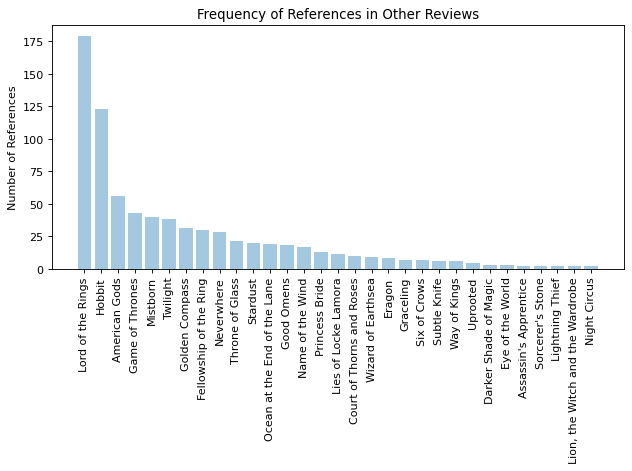

In [157]:
from matplotlib.pyplot import figure

keys = [key for (key, value) in refs.most_common()]
x_pos = np.arange(len(keys))
counts = [refs[k] for k in keys]

fig = figure(figsize=(8, 6), dpi=80)
plt.bar(x_pos, counts, align='center', alpha=0.4)
plt.xticks(x_pos, keys, rotation=90)
plt.ylabel('Number of References')
plt.title('Frequency of References in Other Reviews')
plt.tight_layout()
plt.savefig("images/references.png")
plt.show()

It is no surprise that Tolkien dominates this list, however American Gods being referenced more frequently than Game of Thrones is interesting considering the latter's cultural significance. My best explanation for this is that a Game of Thrones has a handy, widely-used acronym (aGoT or just GoT) for use in discussions. American Gods, however, does not.

This is an issue with a lot of these books, as acronyms are especially common in fantasy discussions (lotr, asoiaf, wot, hp, etcetera). It would be possible to automate a way of acronymizing all of these titles, but I unfortunately do not have the time to work that out.

### Most frequently referenced (positive vs. negative)

In [158]:
pos_refs = Counter()
neg_refs = Counter()

title_series = pd.Series([title.text for title in new_titles])
for title in title_series:
    ind = title_series[title_series == title].index[0]
    original = titles[ind]
    other_df = sentiment_df[sentiment_df.index != original.text]
    for i in range(other_df.shape[0]):
        if title.lower() in other_df.iloc[i].Text.lower():
            if other_df.iloc[i].Sentiment == 'pos':
                pos_refs.update([title])
            else:
                neg_refs.update([title])

In [159]:
pos_refs_total = sum(pos_refs.values())
neg_refs_total = sum(neg_refs.values())

for k in pos_refs.keys():
    pos_refs[k] = np.round(pos_refs[k]/pos_refs_total, decimals=3)
    
for k in neg_refs.keys():
    neg_refs[k] = np.round(neg_refs[k]/neg_refs_total, decimals=3)

pos_refs.most_common()
neg_refs.most_common()

[('Lord of the Rings', 0.27), ('Hobbit', 0.178), ('American Gods', 0.073), ('Game of Thrones', 0.071), ('Fellowship of the Ring', 0.05), ('Mistborn', 0.039), ('Stardust', 0.037), ('Twilight', 0.037), ('Neverwhere', 0.034), ('Golden Compass', 0.032), ('Ocean at the End of the Lane', 0.032), ('Name of the Wind', 0.027), ('Court of Thorns and Roses', 0.018), ('Good Omens', 0.016), ('Throne of Glass', 0.016), ('Wizard of Earthsea', 0.014), ('Subtle Knife', 0.011), ('Graceling', 0.009), ('Six of Crows', 0.007), ('Lies of Locke Lamora', 0.007), ('Lightning Thief', 0.005), ('Princess Bride', 0.005), ('Uprooted', 0.005), ('Darker Shade of Magic', 0.002), ('Eye of the World', 0.002), ('Way of Kings', 0.002)]

[('Lord of the Rings', 0.189), ('Hobbit', 0.139), ('American Gods', 0.074), ('Mistborn', 0.071), ('Twilight', 0.068), ('Golden Compass', 0.053), ('Throne of Glass', 0.043), ('Neverwhere', 0.04), ('Game of Thrones', 0.037), ('Good Omens', 0.034), ('Princess Bride', 0.034), ('Eragon', 0.025), ('Fellowship of the Ring', 0.025), ('Lies of Locke Lamora', 0.025), ('Name of the Wind', 0.015), ('Ocean at the End of the Lane', 0.015), ('Way of Kings', 0.015), ('Six of Crows', 0.012), ('Stardust', 0.012), ('Wizard of Earthsea', 0.009), ('Graceling', 0.009), ('Court of Thorns and Roses', 0.006), ('Darker Shade of Magic', 0.006), ("Assassin's Apprentice", 0.006), ("Sorcerer's Stone", 0.006), ('Eye of the World', 0.006), ('Lion, the Witch and the Wardrobe', 0.006), ('Night Circus', 0.006), ('Uprooted', 0.006), ('Subtle Knife', 0.003)]

In [160]:
print('Total Positive References:',pos_refs_total)
print('Total Negative References:',neg_refs_total)

Total Positive References: 437
Total Negative References: 323


In [161]:
# Comparison of most common references in positive (left) vs. negative (right) reviews

i = 1
for pos, neg in zip(pos_refs.most_common(), neg_refs.most_common()):
    print(str(i)+'.)',pos,"\t",neg)
    i+=1

1.) ('Lord of the Rings', 0.27) 	 ('Lord of the Rings', 0.189)
2.) ('Hobbit', 0.178) 	 ('Hobbit', 0.139)
3.) ('American Gods', 0.073) 	 ('American Gods', 0.074)
4.) ('Game of Thrones', 0.071) 	 ('Mistborn', 0.071)
5.) ('Fellowship of the Ring', 0.05) 	 ('Twilight', 0.068)
6.) ('Mistborn', 0.039) 	 ('Golden Compass', 0.053)
7.) ('Stardust', 0.037) 	 ('Throne of Glass', 0.043)
8.) ('Twilight', 0.037) 	 ('Neverwhere', 0.04)
9.) ('Neverwhere', 0.034) 	 ('Game of Thrones', 0.037)
10.) ('Golden Compass', 0.032) 	 ('Good Omens', 0.034)
11.) ('Ocean at the End of the Lane', 0.032) 	 ('Princess Bride', 0.034)
12.) ('Name of the Wind', 0.027) 	 ('Eragon', 0.025)
13.) ('Court of Thorns and Roses', 0.018) 	 ('Fellowship of the Ring', 0.025)
14.) ('Good Omens', 0.016) 	 ('Lies of Locke Lamora', 0.025)
15.) ('Throne of Glass', 0.016) 	 ('Name of the Wind', 0.015)
16.) ('Wizard of Earthsea', 0.014) 	 ('Ocean at the End of the Lane', 0.015)
17.) ('Subtle Knife', 0.011) 	 ('Way of Kings', 0.015)
18.) (

In [162]:
# Direct comparison of books referenced in both positive (left) and negative (right) contexts...

refs_zipped = [(pos, neg) for pos in sorted(pos_refs.items()) for neg in sorted(neg_refs.items()) if pos[0]==neg[0]]

for pos, neg in refs_zipped:
    print(pos,'\t',neg)

('American Gods', 0.073) 	 ('American Gods', 0.074)
('Court of Thorns and Roses', 0.018) 	 ('Court of Thorns and Roses', 0.006)
('Darker Shade of Magic', 0.002) 	 ('Darker Shade of Magic', 0.006)
('Eye of the World', 0.002) 	 ('Eye of the World', 0.006)
('Fellowship of the Ring', 0.05) 	 ('Fellowship of the Ring', 0.025)
('Game of Thrones', 0.071) 	 ('Game of Thrones', 0.037)
('Golden Compass', 0.032) 	 ('Golden Compass', 0.053)
('Good Omens', 0.016) 	 ('Good Omens', 0.034)
('Graceling', 0.009) 	 ('Graceling', 0.009)
('Hobbit', 0.178) 	 ('Hobbit', 0.139)
('Lies of Locke Lamora', 0.007) 	 ('Lies of Locke Lamora', 0.025)
('Lord of the Rings', 0.27) 	 ('Lord of the Rings', 0.189)
('Mistborn', 0.039) 	 ('Mistborn', 0.071)
('Name of the Wind', 0.027) 	 ('Name of the Wind', 0.015)
('Neverwhere', 0.034) 	 ('Neverwhere', 0.04)
('Ocean at the End of the Lane', 0.032) 	 ('Ocean at the End of the Lane', 0.015)
('Princess Bride', 0.005) 	 ('Princess Bride', 0.034)
('Six of Crows', 0.007) 	 ('Six o

<BarContainer object of 20 artists>

([<matplotlib.axis.XTick object at 0x19a2c9160>, <matplotlib.axis.XTick object at 0x19a195190>, <matplotlib.axis.XTick object at 0x19a2e6940>, <matplotlib.axis.XTick object at 0x18f0253a0>, <matplotlib.axis.XTick object at 0x18f032400>, <matplotlib.axis.XTick object at 0x18f0323d0>, <matplotlib.axis.XTick object at 0x18ff59970>, <matplotlib.axis.XTick object at 0x18ff598e0>, <matplotlib.axis.XTick object at 0x18ff594c0>, <matplotlib.axis.XTick object at 0x18f0323a0>, <matplotlib.axis.XTick object at 0x18ff6c2e0>, <matplotlib.axis.XTick object at 0x18ff6c6d0>, <matplotlib.axis.XTick object at 0x18ff7f460>, <matplotlib.axis.XTick object at 0x18ff7f3d0>, <matplotlib.axis.XTick object at 0x191f21c70>, <matplotlib.axis.XTick object at 0x18ff7fe20>, <matplotlib.axis.XTick object at 0x18ff6cc70>, <matplotlib.axis.XTick object at 0x18ff59be0>, <matplotlib.axis.XTick object at 0x191f21670>, <matplotlib.axis.XTick object at 0x18efc5af0>], [Text(0, 0, 'Lord of the Rings'), Text(1, 0, 'Hobbit'), T

Text(0, 0.5, 'Relative Frequency')

Text(0.5, 1.0, 'Frequency of References in Other (Positive) Reviews')

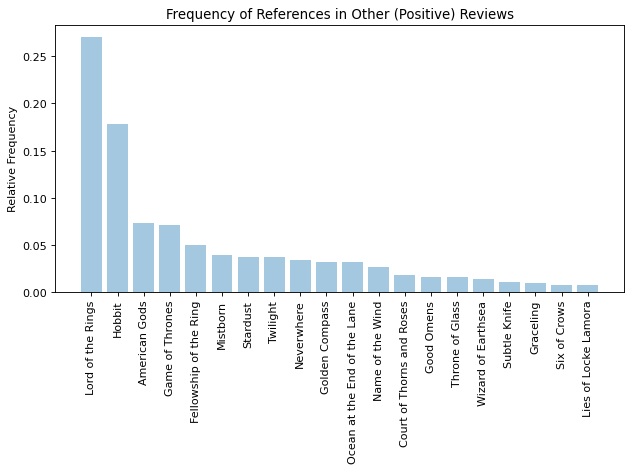

In [163]:
# Relative frequency of references in positive reviews...

keys = [key for (key, value) in pos_refs.most_common(20)]
x_pos = np.arange(len(keys))
counts = [pos_refs[k] for k in keys]

fig = figure(figsize=(8, 6), dpi=80)
plt.bar(x_pos, counts, align='center', alpha=0.4)
plt.xticks(x_pos, keys, rotation = 90)
plt.ylabel('Relative Frequency')
plt.title('Frequency of References in Other (Positive) Reviews')
plt.tight_layout()
plt.savefig("images/neg_refs.png")
plt.show()

<BarContainer object of 20 artists>

([<matplotlib.axis.XTick object at 0x191f45190>, <matplotlib.axis.XTick object at 0x191f45370>, <matplotlib.axis.XTick object at 0x191f3f550>, <matplotlib.axis.XTick object at 0x18f26b730>, <matplotlib.axis.XTick object at 0x18f26bb80>, <matplotlib.axis.XTick object at 0x1957ce8b0>, <matplotlib.axis.XTick object at 0x19570e250>, <matplotlib.axis.XTick object at 0x18f27e7c0>, <matplotlib.axis.XTick object at 0x18f27e730>, <matplotlib.axis.XTick object at 0x1957ce760>, <matplotlib.axis.XTick object at 0x19a89dbe0>, <matplotlib.axis.XTick object at 0x19477d8b0>, <matplotlib.axis.XTick object at 0x19476be20>, <matplotlib.axis.XTick object at 0x19476b5e0>, <matplotlib.axis.XTick object at 0x18de6ad90>, <matplotlib.axis.XTick object at 0x19476b850>, <matplotlib.axis.XTick object at 0x19477d850>, <matplotlib.axis.XTick object at 0x18f27e2e0>, <matplotlib.axis.XTick object at 0x18f413a60>, <matplotlib.axis.XTick object at 0x194773f70>], [Text(0, 0, 'Lord of the Rings'), Text(1, 0, 'Hobbit'), T

Text(0, 0.5, 'Relative Frequency')

Text(0.5, 1.0, 'Frequency of References in Other (Negative) Reviews')

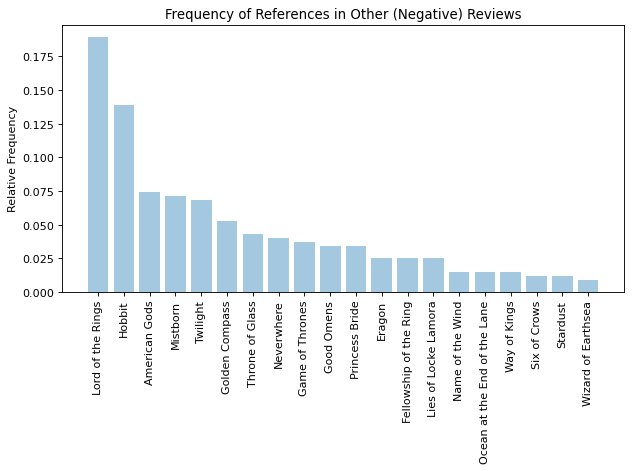

In [164]:
# Relative frequency of references in negative reviews

keys = [key for (key, value) in neg_refs.most_common(20)]
x_pos = np.arange(len(keys))
counts = [neg_refs[k] for k in keys]

fig = figure(figsize=(8, 6), dpi=80)
plt.bar(x_pos, counts, align='center', alpha=0.4)
plt.xticks(x_pos, keys, rotation = 90)
plt.ylabel('Relative Frequency')
plt.title('Frequency of References in Other (Negative) Reviews')
plt.tight_layout()
plt.savefig("images/neg_refs.png")
plt.show()

It is interesting that, although lord of the rings and the hobbit are still on top in terms of references, in the frequency of negative reviews, the other titles have room to breathe. Not too much else can be said of these differences. Ultimately, a reference in any kind of review can be either good or bad depending on the context. Still, it is an interesting comparison

### Gendered pronouns by book

We noticed in the pronoun analysis that third-person feminine pronouns are used much more frequently in negative reviews. This perhaps hints at a degree of bias in goodreads reviews concerning female characters in fantasy, but we need more information. Unfortunately, our data does not include anything about the protagonists of a given novel, but we can use the proportion of masculine/feminine third-person pronouns in reviews to get a rough idea for what kinds of characters are being discussed from each book.

NOTE: This is in no way a perfect means of determining whether a book features predominantly male or female characters (since third-person pronouns could just as well be referring to the author or to someone totally random as part of a personal anecdote), but it should let us know if what we're seeing with gendered pronouns is a potential trend or just coincidence.

In [165]:
# First, we count mentions of masculine and feminine pronouns in reviews of each title...

gender_dict = {}
for title in titles:
    if title not in gender_dict.keys():
        gender_dict[title.text] = Counter()
    this_df = sentiment_df.loc[title.text]
    for text in this_df.Spacy:
        for tok in text:
            if tok.lemma_ == 'she' or tok.lemma_ == 'her':
                gender_dict[title.text].update(['fem'])
            elif tok.lemma_ == 'he' or tok.lemma_ == 'his':
                gender_dict[title.text].update(['masc'])                

In [166]:
# gender_dict = {k.text: gender_dict[k] for k in gender_dict.keys()}

In [167]:
for k in gender_dict.keys():
    print(k+':\t(fem:', str(gender_dict[k]['fem'])+', masc:',str(gender_dict[k]['masc'])+')')

A Court of Thorns and Roses:	(fem: 1107, masc: 770)
A Darker Shade of Magic:	(fem: 519, masc: 661)
A Game of Thrones:	(fem: 316, masc: 700)
A Wizard of Earthsea:	(fem: 238, masc: 762)
American Gods:	(fem: 48, masc: 711)
Assassin's Apprentice:	(fem: 134, masc: 780)
Eragon:	(fem: 106, masc: 833)
Good Omens: The Nice and Accurate Prophecies of Agnes Nutter, Witch:	(fem: 103, masc: 395)
Graceling:	(fem: 1346, masc: 516)
Harry Potter and the Sorcerer's Stone:	(fem: 234, masc: 542)
Neverwhere:	(fem: 174, masc: 828)
Six of Crows:	(fem: 430, masc: 686)
Stardust:	(fem: 332, masc: 767)
The Color of Magic:	(fem: 5, masc: 265)
The Eye of the World:	(fem: 158, masc: 678)
The Fellowship of the Ring:	(fem: 27, masc: 842)
The Final Empire:	(fem: 309, masc: 497)
The Golden Compass:	(fem: 348, masc: 261)
The Hobbit, or There and Back Again:	(fem: 16, masc: 525)
The Lies of Locke Lamora:	(fem: 39, masc: 684)
The Lightning Thief:	(fem: 94, masc: 432)
The Lion, the Witch and the Wardrobe:	(fem: 98, masc: 2

In [168]:
# Let's look specifically at those in which third-person feminine pronouns are used more often than masculine...

fem_indices = []
for k in gender_dict.keys():
    counter = gender_dict[k]
    if counter['fem'] > counter['masc']:
        fem_indices.append(k)

fem_indices

['A Court of Thorns and Roses', 'Graceling', 'The Golden Compass', 'The Night Circus', 'Throne of Glass', 'Twilight', 'Uprooted']

Thankfully, this list is quite small. A quick google search tells us that each of these books does indeed have at least one female protagonist. Just eyeballing the other titles, the only other book with a female protagonist that seems to be missing is The Final Empire. Overall, a pretty good list.

In [169]:
# Now we look at how these books were reviewed

for i in fem_indices:
    reviews = sentiment_df.loc[i]
    print(i)
    print(reviews.Sentiment.value_counts())
    print()

A Court of Thorns and Roses
neg    64
pos    47
Name: Sentiment, dtype: int64

Graceling
neg    59
pos    56
Name: Sentiment, dtype: int64

The Golden Compass
neg    56
pos    54
Name: Sentiment, dtype: int64

The Night Circus
neg    66
pos    52
Name: Sentiment, dtype: int64

Throne of Glass
neg    62
pos    53
Name: Sentiment, dtype: int64

Twilight
neg    62
pos    56
Name: Sentiment, dtype: int64

Uprooted
pos    59
neg    59
Name: Sentiment, dtype: int64



With the exception of the Golden Compass, all of these books seem to be predominantly negatively reviewed.

In [170]:
pos_books = []
neg_books = []

for i in sentiment_df.index.unique():
    vc = sentiment_df.loc[i].Sentiment.value_counts()
    if vc['neg'] > vc['pos']:
        neg_books.append(i)
    else:
        pos_books.append(i)

pos_books
neg_books

['A Darker Shade of Magic', 'A Wizard of Earthsea', 'American Gods', "Assassin's Apprentice", 'Good Omens: The Nice and Accurate Prophecies of Agnes Nutter, Witch', 'Neverwhere', 'Six of Crows', 'Stardust', 'The Color of Magic', 'The Eye of the World', 'The Fellowship of the Ring', 'The Final Empire', 'The Hobbit, or There and Back Again', 'The Lion, the Witch and the Wardrobe', 'The Lord of the Rings', 'The Ocean at the End of the Lane', 'Uprooted']

['A Court of Thorns and Roses', 'A Game of Thrones', 'Eragon', 'Graceling', "Harry Potter and the Sorcerer's Stone", 'The Golden Compass', 'The Lies of Locke Lamora', 'The Lightning Thief', 'The Name of the Wind', 'The Night Circus', 'The Princess Bride', 'The Subtle Knife', 'The Way of Kings', 'Throne of Glass', 'Twilight']

In [171]:
for book in neg_books:
    print(book, '(fem:',str(gender_dict[book]['fem'])+', masc:',str(gender_dict[book]['masc'])+')')          

A Court of Thorns and Roses (fem: 1107, masc: 770)
A Game of Thrones (fem: 316, masc: 700)
Eragon (fem: 106, masc: 833)
Graceling (fem: 1346, masc: 516)
Harry Potter and the Sorcerer's Stone (fem: 234, masc: 542)
The Golden Compass (fem: 348, masc: 261)
The Lies of Locke Lamora (fem: 39, masc: 684)
The Lightning Thief (fem: 94, masc: 432)
The Name of the Wind (fem: 149, masc: 1350)
The Night Circus (fem: 330, masc: 165)
The Princess Bride (fem: 218, masc: 618)
The Subtle Knife (fem: 192, masc: 269)
The Way of Kings (fem: 138, masc: 717)
Throne of Glass (fem: 1962, masc: 623)
Twilight (fem: 1181, masc: 898)


In [245]:
fem_genres = Counter()
for i in fem_indices:
    this_df = reviews_df.loc[i]
    for glist in this_df.Genres:
        for genre in glist:
            fem_genres.update([genre])
            
i = 1
for g in fem_genres.most_common(10):
    print(str(i)+'.)',g[0])
    i += 1

fem_shelves = Counter()
for i in fem_indices:
    this_df = reviews_df.loc[i]
    for shlist in this_df.Shelves:
        for shelf in glist:
            fem_shelves.update([shelf])

fem_shelves.most_common()

1.) 'Fantasy'
2.) 'Young Adult'
3.) 'Romance'
4.) 'Fiction'
5.) 'Magic'
6.) 'Paranormal'
7.) 'High Fantasy'
8.) 'New Adult'
9.) 'Young Adult Fantasy'
10.) 'Adventure'


[("'Fantasy'", 3220), ("'Young Adult'", 805), ("'Fiction'", 805), ("'Romance'", 805), ("'Magic'", 805), ("'Fairy Tales'", 805), ("'High Fantasy'", 805), ("'Adult'", 805), ("'Retellings'", 805), ("'New Adult'", 805)]

Most of these books are tagged either as "young adult" or "romance". This complicates the analysis, as both of these subgenres are typically dominated by female protagonists and both of them are frequently looked down upon and belittled (less-so nowadays, but still). There may be a degree of misogyny behind these attitudes, but it is difficult to tell if it's the presence of female characters that is causing the negative skew or just the genre itself. Likely it is both, but we've reached the end of what we can study with our data set.

## Part 7: Non-Lexical Data Analysis

In [173]:
# First create a copy of reviews_df without the extraneous columns

nonlex_df = sentiment_df.drop(['Text', 'Spacy', 'Genres', 'Shelves'], axis=1).copy()
nonlex_df.info()
nonlex_df.sample(10)

<class 'pandas.core.frame.DataFrame'>
Index: 3549 entries, A Court of Thorns and Roses to Uprooted
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Year       3549 non-null   int64  
 1   Rating     3549 non-null   int64  
 2   Likes      3549 non-null   int64  
 3   Date       3549 non-null   object 
 4   Toks       3549 non-null   int64  
 5   Types      3549 non-null   int64  
 6   TTR        3549 non-null   float64
 7   Sentiment  3549 non-null   object 
dtypes: float64(1), int64(5), object(2)
memory usage: 314.1+ KB


,Year,Rating,Likes,Date,Toks,Types,TTR,Sentiment
Title,,,,,,,,
The Fellowship of the Ring,1954,2,565,2016-07-29,86,71,0.825581,pos
Harry Potter and the Sorcerer's Stone,1997,1,28,2013-11-11,378,211,0.558201,neg
The Ocean at the End of the Lane,2013,5,200,2013-07-08,471,211,0.447983,pos
The Lord of the Rings,1955,4,64,2011-09-23,65,52,0.800000,neg
A Wizard of Earthsea,1968,4,55,2018-02-16,287,167,0.581882,pos
A Wizard of Earthsea,1968,2,92,2010-10-23,354,186,0.525424,neg
The Night Circus,2011,1,109,2011-09-09,805,385,0.478261,neg
"The Hobbit, or There and Back Again",1937,1,43,2007-10-01,232,138,0.594828,neg
A Game of Thrones,1996,3,26,2015-04-12,117,80,0.683761,pos


In [174]:
nonlex_df.Date = nonlex_df.Date.map(lambda d: d.year)
nonlex_df.sample(5)

,Year,Rating,Likes,Date,Toks,Types,TTR,Sentiment
Title,,,,,,,,
"The Lion, the Witch and the Wardrobe",1950,2,11,2017,74,59,0.797297,neg
"The Lion, the Witch and the Wardrobe",1950,4,56,2018,158,108,0.683544,pos
The Night Circus,2011,4,282,2012,73,56,0.767123,pos
A Wizard of Earthsea,1968,4,291,2012,822,371,0.451338,pos
Stardust,1998,4,100,2010,65,52,0.800000,pos


### Ratings Correlation

In [175]:
from scipy.stats import kendalltau

tau, p = kendalltau(nonlex_df.Likes, nonlex_df.Rating)
print('Likes-Rating Correlation...')
print('\ttau:',tau)
print('\tp-value:',p)
print()

tau, p = kendalltau(nonlex_df.Toks, nonlex_df.Rating)
print('Tokens-Rating Correlation...')
print('\ttau:',tau)
print('\tp-value:',p)
print()

tau, p = kendalltau(nonlex_df.Types, nonlex_df.Rating)
print('Types-Rating Correlation...')
print('\ttau:',tau)
print('\tp-value:',p)
print()

tau, p = kendalltau(nonlex_df.TTR, nonlex_df.Rating)
print('TTR-Rating Correlation...')
print('\ttau:',tau)
print('\tp-value:',p)
print()

tau, p = kendalltau(nonlex_df.Year, nonlex_df.Rating)
print('Publication Year-Rating Correlation...')
print('\ttau:',tau)
print('\tp-value:',p)
print()

tau, p = kendalltau(nonlex_df.Date, nonlex_df.Rating)
print('Review Date-Rating Correlation...')
print('\ttau:',tau)
print('\tp-value:',p)
print()

Likes-Rating Correlation...
	tau: 0.4040868398714471
	p-value: 5.249072962461497e-237

Tokens-Rating Correlation...
	tau: 0.06319646489356705
	p-value: 2.6056460169143904e-07

Types-Rating Correlation...
	tau: 0.06534786564532971
	p-value: 1.0232773290074498e-07

TTR-Rating Correlation...
	tau: -0.05241783760392383
	p-value: 1.9368212320287506e-05

Publication Year-Rating Correlation...
	tau: -0.008429843950322962
	p-value: 0.5030329414954429

Review Date-Rating Correlation...
	tau: 0.04246780963551583
	p-value: 0.000848237987944654



Consistent with our earlier analysis, likes and rating are pretty strongly correlated. Everything else is a bit weaker, but the only insignificant correlation is between publication year and rating, which seemed the least likely correlation anyways. Date of review is also only weakly correlated

### PCA + KNN

In [176]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

x_train, x_test, y_train, y_test = train_test_split(nonlex_df.drop(['Rating','Sentiment'], axis=1), nonlex_df.Rating, 
                                                    test_size = 0.20, random_state = 0)

scaled_train = StandardScaler().fit_transform(x_train)
pca = PCA()
pca.fit(scaled_train)
pca_data = pca.transform(scaled_train)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

<BarContainer object of 6 artists>

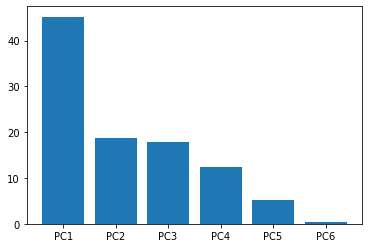

In [177]:
per_var = np.round(pca.explained_variance_ratio_*100, decimals=1)
labels = ['PC'+ str(x) for x in range(1, len(per_var)+1)]

plt.bar(x=range(1, len(per_var)+1), height=per_var, tick_label=labels)
plt.show()

In [178]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()
scaler = StandardScaler()
pca = PCA()
pipe = Pipeline([('scale',scaler), ('pca', pca), ('clf',knn_clf)])

param_grid = {"clf__n_neighbors": list(range(5, 40)),
              "pca__n_components":[2,3,5]}

grid_knn = GridSearchCV(pipe, param_grid, cv=5, verbose=1)
grid_knn.fit(x_train, y_train)

Fitting 5 folds for each of 105 candidates, totalling 525 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 525 out of 525 | elapsed:   16.2s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scale',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('pca',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=None,
                                            random_state=None,
                                            svd_solver='auto', tol=0.0,
                                            whiten=False)),
                                       ('clf',
                                        KNeighborsClassifier(algorithm='auto',
                                                             leaf_size=30,
                                                             metric='minkowsk

In [179]:
grid_knn.best_score_
grid_knn.best_params_

0.3346312442556574

{'clf__n_neighbors': 5, 'pca__n_components': 5}

In [180]:
knn_pred = grid_knn.predict(x_test)
sklearn.metrics.accuracy_score(y_test, knn_pred)

0.37464788732394366

### PCA + LinearRegression

In [181]:
reg = LinearRegression()
scaler = StandardScaler()
pca = PCA()
pipe = Pipeline([('scale',scaler), ('pca', pca), ('reg', reg)])

param_grid = {"reg__normalize": [True, False],
              "pca__n_components":[2, 3, 4, 5, 6]}

grid_reg = GridSearchCV(pipe, param_grid, cv=5, verbose=1)
grid_reg.fit(x_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.5s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scale',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('pca',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=None,
                                            random_state=None,
                                            svd_solver='auto', tol=0.0,
                                            whiten=False)),
                                       ('reg',
                                        LinearRegression(copy_X=True,
                                                         fit_intercept=True,
                                                         n_jobs=None,
              

In [182]:
grid_reg.best_score_
grid_reg.best_params_

0.037011391874862756

{'pca__n_components': 6, 'reg__normalize': False}

In [183]:
preds = grid_reg.best_estimator_.predict(x_test)
r2_score(y_test, preds)
mean_squared_error(y_test, preds)

0.04190281475837365

1.940448046700012

Both of these classifiers are significantly worse than their lexical counterparts. In this case, outside of likes, non-lexical data seems to have little bearing on review scores.